# Notebook and Repository Analysis

This notebook performs an exploratory analysis of 1.25 million Jupyter notebooks on Github and their repositories. I'll try to clean the notebook as I go, but some of this may be messy.

In [1]:
import os
import json
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# 0. Import Notebook, Cell, Repo, and Readme Data

In [2]:
# load data from our csv files
df_nb = pd.read_csv('../data/csv/nb_metadata.csv')
df_cell = pd.read_csv('../data/csv/cell_metadata.csv')
df_repo = pd.read_csv('../data/csv/repo_metadata.csv')
df_readme = pd.read_csv('../data/csv/repo_readme.csv')

In [3]:
# filter out forked repos
df_nb = df_nb[df_nb.repo_fork == False] 

# remove unwanted columns
del df_nb['Unnamed: 0']
del df_nb['max_filesize']
del df_nb['min_filesize']
del df_nb['owner_html_url']
del df_nb['query_page']
del df_nb['repo_private']
del df_nb['repo_fork']
del df_nb['repo_html_url']
del df_nb['kernel_lang']
del df_nb['kernel_name']
del df_nb['num_cells']

In [4]:
# clean cell data
del df_cell['Unnamed: 0']
del df_cell['Unnamed: 0.1']

df_cell['workbook_index'].fillna(0, inplace = True)
df_cell['workbook_index'] = df_cell['workbook_index'].astype(int)

df_cell['num_words'].fillna(0, inplace = True)
df_cell['num_words'] = df_cell['num_words'].astype(int)

df_cell['lines_of_code'].fillna(0, inplace = True)
df_cell['lines_of_code'] = df_cell['lines_of_code'].astype(int)

In [5]:
# filter out forked repos
df_repo = df_repo[df_repo.fork == False] 

# deleted unnecessary columns
del df_repo['stargazers_count']
del df_repo['Unnamed: 0']
del df_repo['fork']
del df_repo['private']

In [6]:
# delete unnecesary columns in readme data
del df_readme['Unnamed: 0']
del df_readme['type']

# 1.0 Reduce dataset to notebooks with complete data

Find how many notebooks we did not download metadata for, and reduce our dataframes to include only these.

In [7]:
# 1. num nbs that did not download 
num_nbs_not_queried = 0
missed_ranges = []

num_nbs_bad_result = 0
ranges_w_bad_result = []

# find notebooks not downloaded due to more than 1000 notebooks having same filesize
with open ('../logs/nb_metadata_query_log.txt', 'r') as log:
    for l in log:
        if l.startswith('TOO MANY RESULTS'):
            num_nbs_not_queried += int(l.split()[-2])
            missed_ranges.append(l.split()[-4])

# find notebooks not downloaded due to incomplete response from github
with open('../logs/nb_metadata_cleaning_log.txt', 'r') as log:
    for l in log:
        parts = l.split()        
        if parts[2] == 'incomplete':
            with open('../data/api_results/nb_metadata/' + parts[0], 'r') as json_file:                            
                file_dict = json.load(json_file)
                total_expected = file_dict['total_count']
                expected_pages = math.ceil(total_expected / 100.0)
                current_page = int(parts[0].split('_')[-1].split('.')[0][1:])
                current_items = len(file_dict['items'])
                
                if current_page < expected_pages and current_items < 100:
                    num_nbs_bad_result += (100 - current_items)
                    ranges_w_bad_result.append(l.split('_')[2:4])
                elif total_expected % 100 > current_items:
                    num_nbs_bad_result += (total_expected % 100 - current_items)
                    ranges_w_bad_result.append(l.split('_')[2:4])

num_nbs_did_not_download = num_nbs_not_queried + num_nbs_bad_result

# 2. nbs with metadata
nbs_w_file = df_nb.nb_id.unique()

# 3. nbs with cell data
df_nb_content_count = ( df_cell[[
                            'nb_id', 
                            'lines_of_code', 
                            'num_words']]
                                .groupby('nb_id')
                                .sum() )

nbs_wo_content = list( df_nb_content_count[
    df_nb_content_count.lines_of_code == 0][
    df_nb_content_count.num_words == 0].index )

nbs_w_cells = df_cell[~df_cell.nb_id.isin(nbs_wo_content)].nb_id.unique()

# 4. nbs with repo metadata
repos_w_metadata = df_repo.id.unique()
nbs_w_repo_data = df_nb[df_nb.repo_id.isin(repos_w_metadata)]['nb_id']

# 5. nbs with all data
nb_repo_cell_ids = np.intersect1d(np.intersect1d(nbs_w_file, nbs_w_repo_data), nbs_w_cells)
nb_repo_ids = df_nb[df_nb.nb_id.isin(nb_repo_cell_ids)]['repo_id'].unique()

# 6. repos with all data

print('Of the %s notebooks available on Github'% (df_nb.shape[0] + num_nbs_did_not_download))
print('%s were returned by our search query' % df_nb.shape[0])
print('%s notebooks not returned by our search' % num_nbs_did_not_download)
print('')
print('%s had repo data we could scrape' % nbs_w_repo_data.shape[0])
print('%s had cell data we could extract' % nbs_w_cells.shape[0])
print('Leaving %s that we can analyze fully' % nb_repo_cell_ids.shape[0])
print('')
print('Meaning we have dropped %s nbs in total from the analysis'% (df_nb.shape[0] 
                                                                    + num_nbs_did_not_download 
                                                                    - nb_repo_cell_ids.shape[0]))
print('or %s percent of the dataset' % str((df_nb.shape[0] 
                                         + num_nbs_did_not_download 
                                         - nb_repo_cell_ids.shape[0])
                                         /(df_nb.shape[0] 
                                         + num_nbs_did_not_download)*100)[0:5])

/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Of the 1294163 notebooks available on Github
1250857 were returned by our search query
43306 notebooks not returned by our search

1246469 had repo data we could scrape
1233055 had cell data we could extract
Leaving 1227573 that we can analyze fully

Meaning we have dropped 66590 nbs in total from the analysis
or 5.145 percent of the dataset


In [8]:
df_nb_complete = df_nb[df_nb.nb_id.isin(nb_repo_cell_ids)]
df_repo_complete = df_repo[df_repo.id.isin(nb_repo_ids)]
df_cell_complete = df_cell[df_cell.nb_id.isin(nb_repo_cell_ids)]
df_readme_complete = df_readme[df_readme.repo_id.isin(nb_repo_ids)]

print('Our cleaned data consists of:')
print('%s notebooks' % df_nb_complete.shape[0])
print('%s repos' % df_repo_complete.shape[0])
print('%s readmes' % df_readme_complete.shape[0])
print('%s cells' % df_cell_complete.shape[0])
print('%s users' % df_nb_complete.owner_login.unique().shape[0])

Our cleaned data consists of:
1227573 notebooks
191402 repos
141159 readmes
34486368 cells
100503 users


# 2. Calculate Additional Notebook Data

While we have data about the cells of each notebook, we may want to aggregate this at a notebook level (e.g., how many words of markdown in the entire notebook, not just in each cell.)

In [9]:
# get size of each nb file
nb_files = [x for x in os.listdir('../data/notebooks') if x.endswith('.ipynb')]
sizes = [[n.split('_')[1].split('.')[0], os.path.getsize('../data/notebooks/' + n)] for n in nb_files]

# merge size data back into main table
df_nb_sizes = pd.DataFrame(sizes)
df_nb_sizes.columns = ['nb_id', 'size']
df_nb_complete = df_nb_complete.merge(df_nb_sizes, 
                      on = 'nb_id',
                      how = 'left')

In [10]:
# calculate sum of cell counts for each nb
df_nb_cell_counts = (df_cell[['nb_id',
                             'lines_of_code',
                             'num_display_data', 
                             'num_error', 
                             'num_execute_result', 
                             'num_stream',
                             'num_words', 
                             'num_imports',  
                             'num_headers',
                             'num_links', 
                             'num_functions',
                             'num_classes', 
                             'num_comment_lines', 
                             'num_comment_words']]
                            .groupby('nb_id')
                            .agg('sum'))

df_nb_cell_types = (df_cell[['nb_id', 
                            'cell_type']]
                            .groupby('nb_id')['cell_type']
                            .value_counts()
                            .unstack(fill_value=0))

df_nb_cell_types['nb_id'] = df_nb_cell_types.index
df_nb_cell_counts['nb_id'] = df_nb_cell_counts.index

In [11]:
# get max cell content per nb for calculation of how well markdown, comments, etc are distributed
df_nb_cell_max = (df_cell[['nb_id',
                             'lines_of_code',
                             'num_display_data', 
                             'num_error', 
                             'num_execute_result', 
                             'num_stream',
                             'num_words', 
                             'num_imports',  
                             'num_headers',
                             'num_links', 
                             'num_functions',
                             'num_classes', 
                             'num_comment_lines', 
                             'num_comment_words']]
                            .groupby('nb_id')
                            .agg('max'))

print(df_nb_cell_counts.shape[0])
print(df_nb_cell_max.shape[0])

1239355
1239355


In [12]:
df_nb_cell_types['markdown'] = df_nb_cell_types['markdown'] + df_nb_cell_types['heading']
df_nb_cell_types['other'] = ( df_nb_cell_types['altset']
                             + df_nb_cell_types['future cell']
                             + df_nb_cell_types['interactivecode']
                             + df_nb_cell_types['markdownn']
                             + df_nb_cell_types['moarkdown']
                             + df_nb_cell_types['mycode']
                             + df_nb_cell_types['plaintext']
                             + df_nb_cell_types['strategy']
                             + df_nb_cell_types['task']
                             + df_nb_cell_types['text']
                            )

del df_nb_cell_types['altset']
del df_nb_cell_types['heading']
del df_nb_cell_types['future cell']
del df_nb_cell_types['interactivecode']
del df_nb_cell_types['markdownn']
del df_nb_cell_types['moarkdown']
del df_nb_cell_types['mycode']
del df_nb_cell_types['plaintext']
del df_nb_cell_types['strategy']
del df_nb_cell_types['task']
del df_nb_cell_types['text']

In [13]:
df_nb_complete = df_nb_complete.merge(df_nb_cell_counts,
                                     how = 'left',
                                     on = 'nb_id')


df_nb_complete = df_nb_complete.merge(df_nb_cell_types,
                                     how = 'left',
                                     on = 'nb_id')

In [14]:
df_nb_complete.columns

Index(['nb_id', 'html_url', 'name', 'owner_id', 'owner_login', 'path',
       'repo_description', 'repo_id', 'repo_name', 'nbformat',
       'nbformat_minor', 'lang_name', 'lang_version', 'size', 'lines_of_code',
       'num_display_data', 'num_error', 'num_execute_result', 'num_stream',
       'num_words', 'num_imports', 'num_headers', 'num_links', 'num_functions',
       'num_classes', 'num_comment_lines', 'num_comment_words', 'code',
       'markdown', 'raw', 'other'],
      dtype='object')

# 1. Users

The main findings are:
- about 100,000 people (or accounts) have public notebooks
- most are individual accounts (as opposed to organizations)
- 1/4 of users/organizations only have only 1 notebook
- 1/4 have 10 or more, and these account for the vast majority of notebooks (~ 1 million)

## 1.1 Types of Users

User            93893
Organization     6600
Name: owner_type, dtype: int64


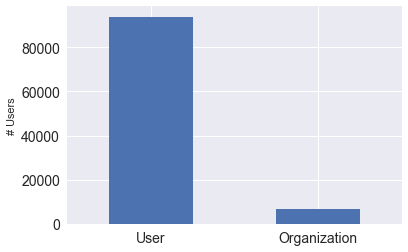

In [15]:
owner_counts = df_repo_complete.drop_duplicates(subset = 'owner_login', 
                                              keep = 'first')['owner_type'].value_counts()

ax = owner_counts.plot(kind='bar',
                       fontsize = 14,
                       rot = 0)
ax.set_ylabel('# Users')

print(owner_counts)

In [16]:
organization_logins = df_repo_complete.drop_duplicates(subset = 'owner_login', keep = 'first')[df_repo_complete.owner_type == 'Organization']['owner_login']
len(organization_logins)

/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


6600

In [17]:
df_nb_complete[df_nb_complete.owner_login.isin(organization_logins)].shape[0]

116669

## 1.2 Notebooks per User

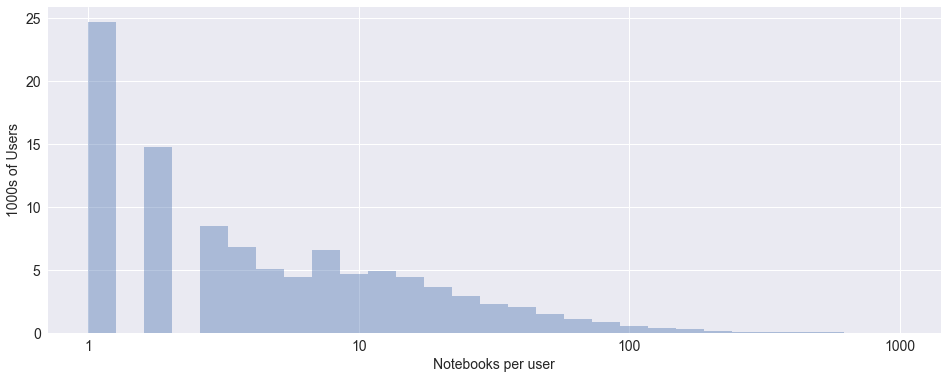

In [18]:
user_nb_counts = df_nb_complete[['owner_login', 'nb_id']].groupby('owner_login').count()

plt.figure(figsize=(16,6))
ax = sns.distplot(user_nb_counts, kde=False, bins = np.logspace(0,3,30))
ax.set_xscale('log')
ax.set_xlabel('Notebooks per user')
ax.set_ylabel('1000s of Users')

from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ticks)

    
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

In [19]:
user_counts = df_nb_complete[['owner_login', 'nb_id']].groupby('owner_login').count()
print('%s users with 1 notebook' % len(user_counts[user_counts.nb_id == 1]))
print('%s users with 10+ notebooks' % len(user_counts[user_counts.nb_id >= 10]))
print('accounting for %s notebooks' % user_counts[user_counts.nb_id >= 10].sum()[0])
print('accounting for %s notebooks' % user_counts[user_counts.nb_id < 10].sum()[0])

24648 users with 1 notebook
27517 users with 10+ notebooks
accounting for 999202 notebooks
accounting for 228371 notebooks


# 2. Repositories

The main insights about the repositories are that:
- about a third of the repositories only have one nb in them
- only about 1/8 of repos have 10 or more files, and these account for the vast majority of notebooks (about 800,000)
- many of the repos with the most notebooks are for textbooks and education

## 2.1 Notebooks per Repository

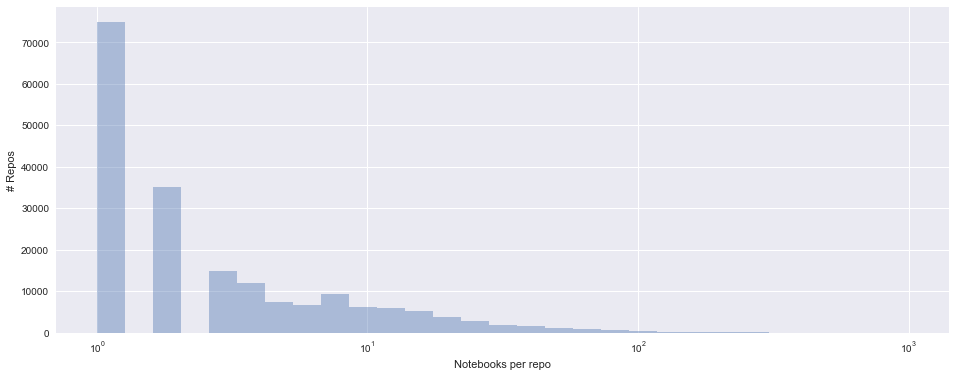

In [20]:
plt.figure(figsize=(16,6))
repo_counts = df_nb_complete.repo_id.value_counts()

ax = sns.distplot(repo_counts, kde=False, bins = np.logspace(0,3,30))
ax.set_xscale('log')
ax.set_xlabel('Notebooks per repo')
ax.set_ylabel('# Repos')

In [21]:
print('%s repos with 1 notebook' % len([x for x in repo_counts if x == 1]))
print('accounting for %s notebooks' % sum([x for x in repo_counts if x == 1]))
print('%s users with 10+ notebooks' % len([x for x in repo_counts if x >= 10]))
print('accounting for %s notebooks' % sum([x for x in repo_counts if x >= 10]))

74894 repos with 1 notebook
accounting for 74894 notebooks
27984 users with 10+ notebooks
accounting for 815026 notebooks


## 2.2 Notebooks per Repository by Owner Type

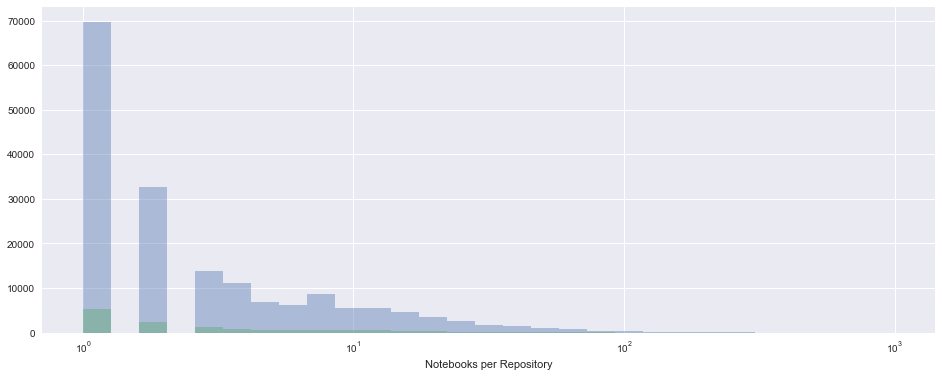

In [22]:
fig, ax = plt.subplots(figsize=(16,6))

ax = sns.distplot(df_nb_complete[~df_nb_complete.owner_login.isin(organization_logins)].repo_id.value_counts(), kde=False, bins = np.logspace(0,3,30))
ax = sns.distplot(df_nb_complete[df_nb_complete.owner_login.isin(organization_logins)].repo_id.value_counts(), kde=False, bins = np.logspace(0,3,30))

ax.set_xscale('log')
ax.set_xlabel('Notebooks per Repository')

In [23]:
print('%s repos have 10 or more notebooks in them' % len(repo_counts[repo_counts >= 10]))
print('Accounting for %s notebooks' % repo_counts[repo_counts >= 10].sum())

27984 repos have 10 or more notebooks in them
Accounting for 815026 notebooks


## 2.3 Repositories with Most Notebooks

In [24]:
df_repo_counts = repo_counts.to_frame("num_nb")
df_repo_counts['repo_id'] = df_repo_counts.index 
df_repo_counts.reset_index(drop=True, inplace=True)

df_repos_full = df_repo_counts.merge(df_nb[['repo_id', 'owner_login', 'repo_name']], how='left', on='repo_id', )
df_repos_full.drop_duplicates(inplace=True, keep='first', subset=['repo_id'])
df_repos_full.reset_index(drop=True, inplace=True)
print(df_repos_full.shape)
df_repos_full.head(10)

(191396, 4)


,num_nb,repo_id,owner_login,repo_name
0,10901,13769471,FOSSEE,Python-Textbook-Companions
1,3618,68774322,wanglongjuan,15-ODE-homework
2,3494,91523680,ucsd-edx,CSE255-DSE230-Grading
3,3050,55120679,TakeToh,pywork
4,1918,84889421,neylemke,fiscomp2017
5,1779,31615018,chrisalbon,notes_on_data_science_machine_learning_and_art...
6,1771,89497485,donwany,DataScienceDude
7,1241,62499937,JonnyRed,IPython-Notebooks
8,1181,71824512,mushgrant,dsi-MarshallGrant
9,1106,71824701,rameshk28,dsi-RameshKattumenu


# 3. Repositories Per User

- the majority of users only have one repo with notebooks in it (~2/3)
- on the flip side, the majority of repos (2/3) belong to users who have more than one repo with notebooks
- about 1/3 of notebooks (429,508) belong to users who only have one repo with notebooks in it

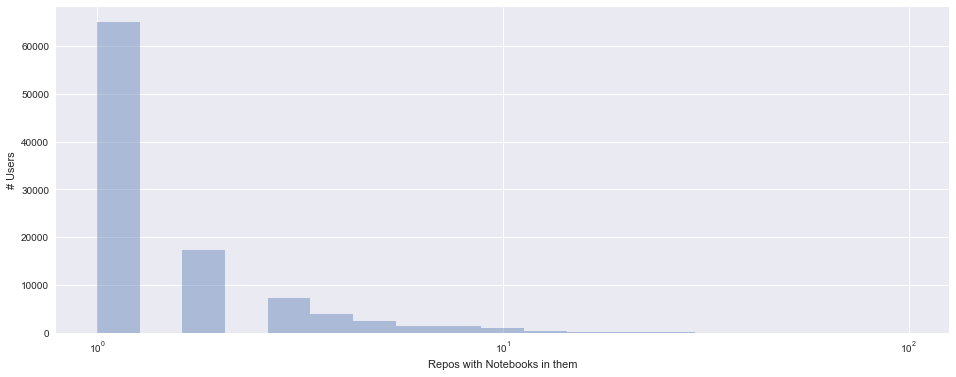

In [25]:
plt.figure(figsize=(16,6))
num_repos_per_user = df_repos_full.groupby(['owner_login'])['num_nb'].count()

ax = sns.distplot(num_repos_per_user, kde=False, bins = np.logspace(0,2,20))
ax.set_xscale('log')
ax.set_xlabel('Repos with Notebooks in them')
ax.set_ylabel('# Users')

In [26]:
nbs_per_user = df_repos_full.groupby(['owner_login'])['num_nb'].sum()

df_nbs_per_user = pd.concat([nbs_per_user, num_repos_per_user], axis=1)
df_nbs_per_user.columns = ['num_nb', 'num_repo']

df_nbs_per_user[df_nbs_per_user.num_repo == 1].sum()

num_nb      424058
num_repo     65039
dtype: int64

# 4. Repository Organizational Attributes

After looking at whether repositories had readmes, pages, issues, wikis, or had been forked, it seems many of these measures cannot be acurately computed from the repo level metadata. For example, most repos say they have downloads and issues and a wiki, but a spot-check of these shows this is not true. I'm not sure what these T/F values represent.

However, the has_pages boolean seems to correctly represent if the repo has a GitHub hosted website, and the issues count seems to be correct.

In [27]:
df_repo_complete.has_downloads.value_counts()

True     191127
False       275
Name: has_downloads, dtype: int64

In [28]:
df_repo_complete.has_issues.value_counts()

True     189857
False      1545
Name: has_issues, dtype: int64

In [29]:
df_repo_complete.has_wiki.value_counts()

True     189606
False      1796
Name: has_wiki, dtype: int64

In [30]:
df_repo_complete.has_pages.value_counts()

False    182758
True       8644
Name: has_pages, dtype: int64

Let's get the percentage of repos and notebooks with a Github hosted page associated with it.

In [31]:
print(df_repo_complete[df_repo_complete.has_pages == True].shape[0] / df_repo_complete.shape[0])
repos_w_pages = df_repo_complete[df_repo_complete.has_pages == True]['id']
df_nb_complete[df_nb_complete.repo_id.isin(repos_w_pages)].shape[0] / df_nb_complete.shape[0]

0.045161492565385944


0.0614464475839726

In [36]:
print('%s repos with readme' %  (df_repo_activity[df_repo_activity['open_issues_count'] > 0].shape[0] / df_repo_activity.shape[0]))
repos_w_readme = df_repo_activity[df_repo_activity['size'] > 0]['repo_id']
print('%s nbs with readme' %  (df_nb_complete[df_nb_complete.repo_id.isin(repos_w_readme)].shape[0] / df_nb_complete.shape[0]))

0.06564194731507508 repos with readme
0.721984761802353 nbs with readme


In [37]:
print('%s repos with issues' %  (df_repo_activity[df_repo_activity['open_issues_count'] > 0].shape[0] / df_repo_activity.shape[0]))
repos_w_issues = df_repo_activity[df_repo_activity['open_issues_count'] > 0]['repo_id']
print('%s nbs with issues' %  (df_nb_complete[df_nb_complete.repo_id.isin(repos_w_issues)].shape[0] / df_nb_complete.shape[0]))

0.06564194731507508 repos with issues
0.088723033171958 nbs with issues


Okay, so the has_issues, has_wiki don't seem to tell us much since they just mean that issues and the wiki are turned on for that repo (which seems to be the default). has_pages does note seem to be the default so we can get some info there, and we can look at the issues count to see about the repos.

In the next plots, let's see if there is a relationship between repo size, forks counts, open issues counts, and watchers count. The plots show, as expected, a somewhat linear relationship with larger repos having more forks, more issues, more watchers, etc. This is not all that interesting.

In [38]:
df_repo_activity = df_repo_complete[['id','html_url','forks_count','watchers_count','subscribers_count', 'open_issues_count']]
df_repo_activity['repo_id'] = df_repo_activity['id']
del df_repo_activity['id']

df_repo_activity = df_repo_activity.merge(df_readme_complete[['repo_id','size']], 
                      how = 'left',
                      on = 'repo_id')

df_repo_activity.head()

/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,html_url,forks_count,watchers_count,subscribers_count,open_issues_count,repo_id,size
0,https://github.com/pingswept/pysolar,59,114,24,5,2058,3226.0
1,https://github.com/ELLIOTTCABLE/Homework,0,4,3,0,66233,441.0
2,https://github.com/chapmanb/bcbb,172,368,54,9,87831,1171.0
3,https://github.com/certik/chess,2,4,4,0,119491,NaN
4,https://github.com/aflaxman/gbd,5,11,3,25,120233,690.0


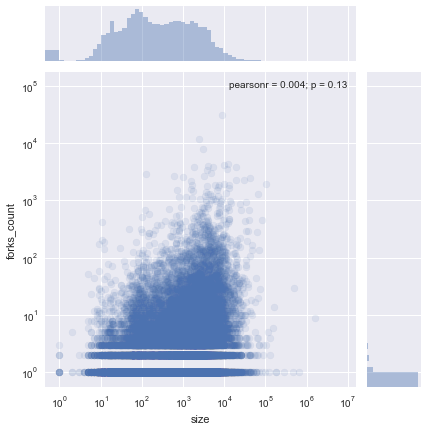

In [39]:
mybins = np.append(0, np.logspace(0,5,50))
g = sns.jointplot("size", 
                  "forks_count", 
                  data=df_repo_activity, 
                  marginal_kws=dict(bins=mybins), 
                  joint_kws={'alpha':0.1})
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')


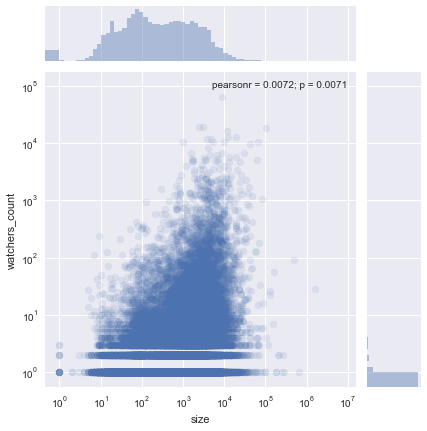

In [40]:
mybins = np.append(0, np.logspace(0,5,50))
g = sns.jointplot("size", 
                  "watchers_count", 
                  data=df_repo_activity, 
                  marginal_kws=dict(bins=mybins), 
                  joint_kws={'alpha':0.1})
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


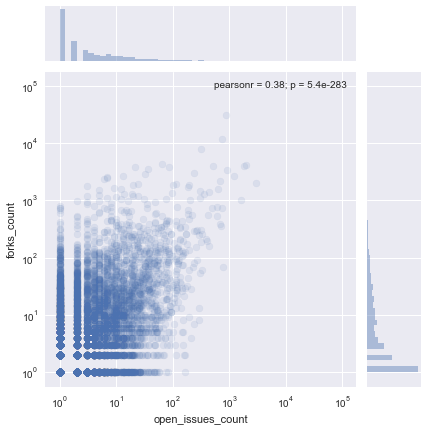

In [41]:
mybins = np.append(0, np.logspace(0,5,50))
g = sns.jointplot("open_issues_count", 
                  "forks_count", 
                  data=df_repo_activity[df_repo_activity.forks_count > 0][df_repo_activity.open_issues_count > 0], 
                  marginal_kws=dict(bins=mybins), 
                  joint_kws={'alpha':0.1})
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

# 5. Notebooks

## 5.1 Languages
- python is the vast majority (over 1 mill) of the notebooks
- python 2.7 is still the favorite, with 3.5, 3.6, and 3.4 catching up
- R and julia come in a respectable 2nd and 3rd place with about 10,000 notebooks each, 

In [42]:
langs = df_nb_complete[['lang_name']]
langs = langs.dropna()

langs.lang_name.replace('Julia', 'julia', inplace=True)
langs.lang_name[~langs.lang_name.isin(['python', 'julia', 'R'])] = 'Other'

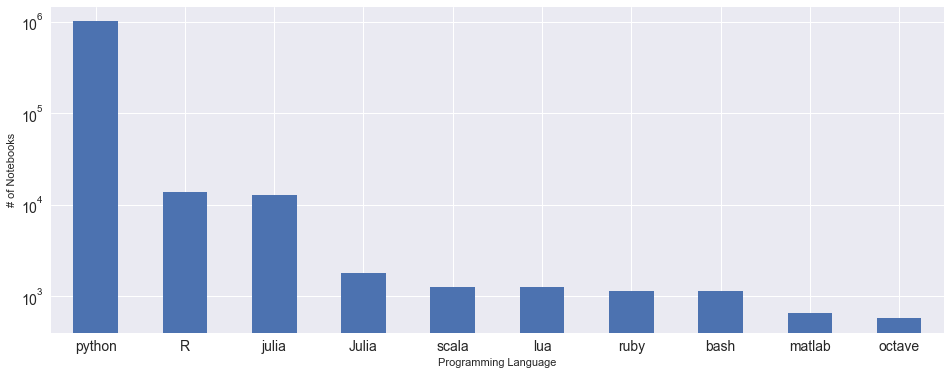

In [44]:
ax = df_nb_complete.lang_name.value_counts()[0:10].plot(kind='bar', 
                                                                   logy=True, 
                                                                   figsize = (16, 6), 
                                                                   fontsize = 14,
                                                                   rot = 0)
ax.set_xlabel('Programming Language')
ax.set_ylabel('# of Notebooks')

In [267]:
print(df_nb_complete.lang_name.value_counts()[0] / df_nb_complete.lang_name.value_counts().sum())
print(df_nb_complete.lang_name.value_counts()[1] / df_nb_complete.lang_name.value_counts().sum())
print(df_nb_complete.lang_name.value_counts()[2] / df_nb_complete.lang_name.value_counts().sum())
print(df_nb_complete.lang_name.value_counts()[3:].sum() / df_nb_complete.lang_name.value_counts().sum())
print(df_nb_complete.lang_name.value_counts().sum() / 1227573)

0.963066388949
0.0130537001125
0.0122626828509
0.011617228087816324
0.8506418762876017


Okay, so python is 96% of all notebooks with a specified language. R and Julia are each about 1%.

Now let's look at versions of python

In [45]:
def trim_version(x):
    x = str(x)
    parts = x.split('.')
    if len(parts) > 2:
        return parts[0] + '.' + parts[1]
    else:
        return x
    
df_nb_complete['trimmed_lang_version'] = df_nb_complete.apply(lambda x: trim_version(x['lang_version']), axis=1)

548364


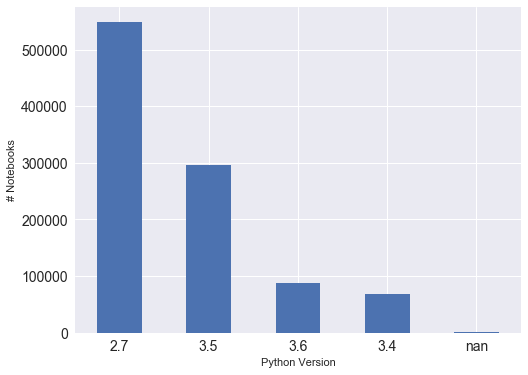

In [46]:
ax = df_nb_complete[df_nb_complete['lang_name'] == 'python']['trimmed_lang_version'].value_counts()[0:5].plot(kind='bar', 
                                                                                                           figsize = (8, 6), 
                                                                                                           fontsize = 14,
                                                                                                           rot = 0)
ax.set_ylabel('# Notebooks')
ax.set_xlabel('Python Version')
print(df_nb_complete[df_nb_complete['lang_name'] == 'python']['trimmed_lang_version'].value_counts()[0])

## 5.2 Cells per Notebook

- 18 cells per notebook
- 12 of these code
- 5 of these markdown

### Markdown Cells

Median of 5.0 cells


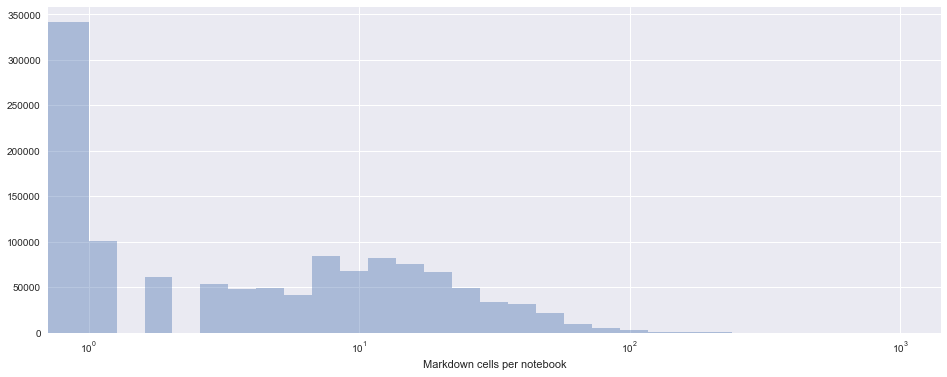

In [49]:
plt.figure(figsize=(16,6))
ax = sns.distplot(df_nb_complete.markdown, kde=False, bins = np.append(0, np.logspace(0,3,30)))
ax.set_xscale('log')
ax.set_xlabel('Markdown cells per notebook')

print('Median of %s cells' % df_nb_complete.markdown.median())

### Code Cells

Median of 12.0 cells


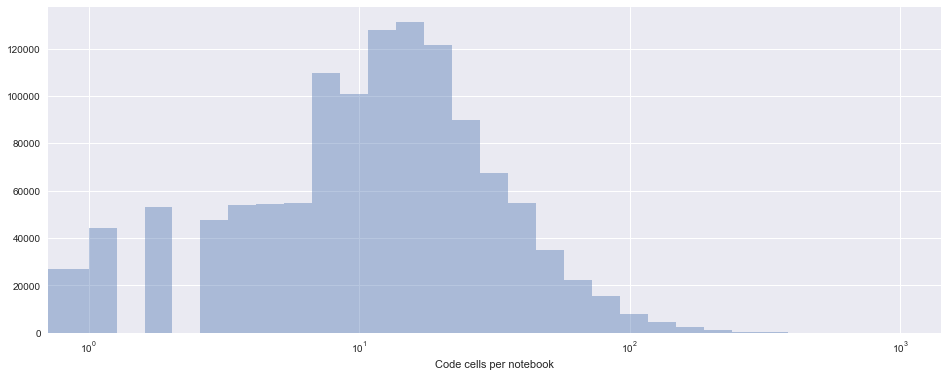

In [50]:
plt.figure(figsize=(16,6))
ax = sns.distplot(df_nb_complete.code, kde=False, bins = np.append(0, np.logspace(0,3,30)))
ax.set_xscale('log')
ax.set_xlabel('Code cells per notebook')

print('Median of %s cells' % df_nb_complete.code.median())

In [51]:
main_cells = df_nb_complete.code.sum() + df_nb_complete.markdown.sum()
non_main_cells = df_nb_complete.other.sum() + df_nb_complete.raw.sum()
non_main_cells / (non_main_cells + main_cells)

0.0021843706109464017

## 5.3 Content per Notebook

- 74 words per notebook
- 79 lines of code per notebook
- 345,685 notebooks without any markdown
- 55,883 notebooks without code
- 6,294 notebooks without either markdown or code

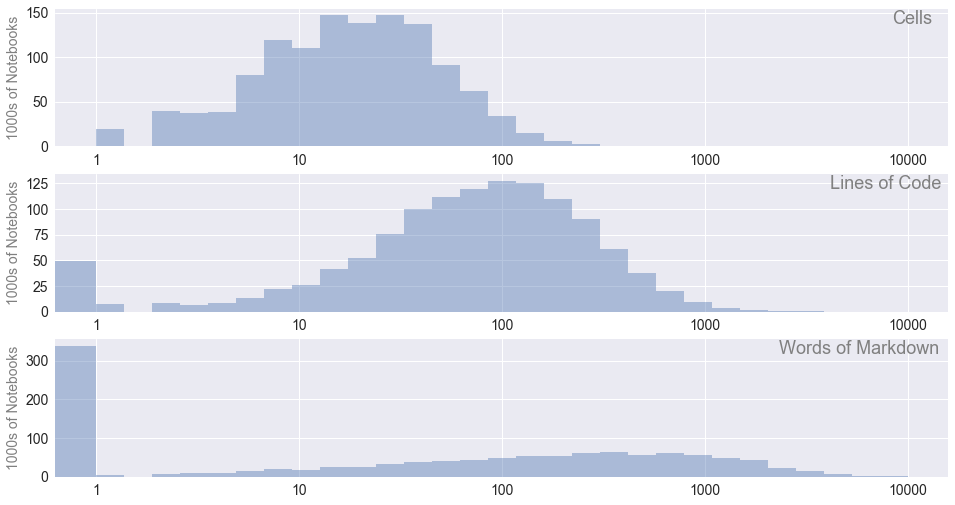

In [48]:
f, (ax1, ax2, ax3) = plt.subplots(3)
f.set_size_inches(16, 4)
plt.subplots_adjust(top=1.75)

df_nb_complete.num_cells = df_nb_complete.code + df_nb_complete.markdown + df_nb_complete.raw + df_nb_complete.other
sns.distplot(df_nb_complete.num_cells, kde=False, ax = ax1, bins = np.append(0, np.logspace(0,4,30)))
ax1.set_xscale('log')
ax1.set_title('Cells', fontsize = 18, position = [0.96, 0.85], color='grey')
ax1.set_ylabel('1000s of Notebooks', color='grey')
ax1.set_xlabel('')
# ax1.title.set_position()
# ax1.title.set_fontsize(18)

sns.distplot(df_nb_complete.lines_of_code, kde=False, ax = ax2, bins = np.append(0, np.logspace(0,4,30)))
ax2.set_xscale('log')
ax2.set_title('Lines of Code', fontsize = 18, position = [0.93, 0.85], color='grey')
ax2.set_ylabel('1000s of Notebooks', color='grey')
ax2.set_xlabel('')

sns.distplot(df_nb_complete.num_words, kde=False, ax = ax3, bins = np.append(0, np.logspace(0,4,30)))
ax3.set_xscale('log')
ax3.set_title('Words of Markdown', fontsize = 18, position = [0.9, 0.85], color='grey')
ax3.set_ylabel('1000s of Notebooks', color='grey', size = 18)
ax3.set_xlabel('')

from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
for axis in [ax1, ax2, ax3]:
    axis.xaxis.set_major_formatter(ScalarFormatter())
    axis.yaxis.set_major_formatter(ticks)

    
for item in ([ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
    
for item in ([ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(14)
    
for item in ([ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(14)
    


In [56]:
print('%s notebooks without words' % df_nb_complete[df_nb_complete.num_words == 0].shape[0])
print('%s notebooks without code' % df_nb_complete[df_nb_complete.lines_of_code == 0].shape[0])
print('%s notebooks without either' % df_nb_complete[df_nb_complete.num_words == 0][df_nb_complete.lines_of_code == 0].shape[0])

338790 notebooks without words
49422 notebooks without code
0 notebooks without either


/Users/doug/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


# 6. Organization

This section looks at how code and markdown is organized across notebooks. Many have all their organizational features in only one cell (e.g., only one cell has functions in it, only one cell had classes in it, etc) but that may be because there is only one function or class in the entire notebook. I did not follow up much further than getting the % of notebooks with each organizational feature.

In [59]:
df_nb_cell_counts.head()

,lines_of_code,num_display_data,num_error,num_execute_result,num_stream,num_words,num_imports,num_headers,num_links,num_functions,num_classes,num_comment_lines,num_comment_words,nb_id
nb_id,,,,,,,,,,,,,,
585,597,7,0,6,1,1687,4,18,1,10,0,281,1878,585
586,215,10,2,5,1,355,3,3,2,5,0,26,18,586
587,346,173,0,14,3,2,23,0,0,2,0,0,0,587
588,355,22,0,1,21,0,16,0,0,5,0,120,389,588
589,78,366,0,1,31,337,7,9,0,0,0,0,0,589


0 null values
1183344 nbs with lines of code
59950 nbs with all code in one cell
0.05066151516380697 nbs with all code in one cell


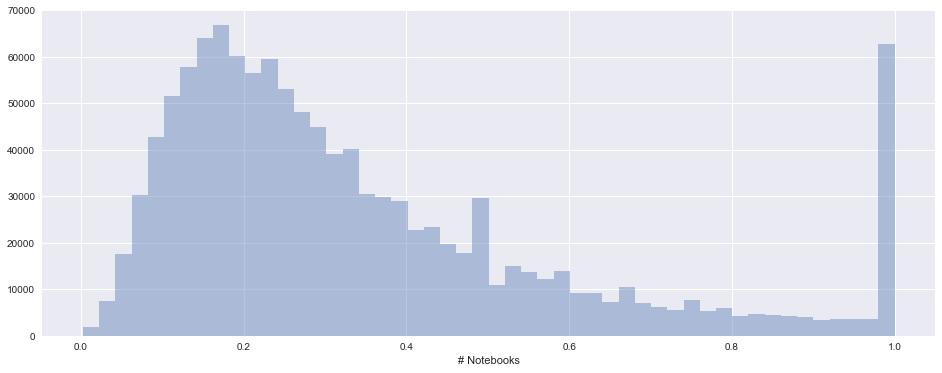

In [60]:
nb_loc_ratio = df_nb_cell_max.lines_of_code / df_nb_cell_counts.lines_of_code
nb_loc_ratio.dropna(inplace = True)
print('%s null values' % nb_loc_ratio.isnull().sum())
print('%s nbs with lines of code' % nb_loc_ratio.shape[0])
print('%s nbs with all code in one cell' % nb_loc_ratio[nb_loc_ratio == 1].shape[0])
print('%s nbs with all code in one cell' % (nb_loc_ratio[nb_loc_ratio == 1].shape[0] / nb_loc_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_loc_ratio, 
                  kde=False)
ax.set_xlabel('Lines of code per notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
892987 nbs with words
102332 nbs with all words in one cell
0.11459517327799845 nbs with all words in one cell


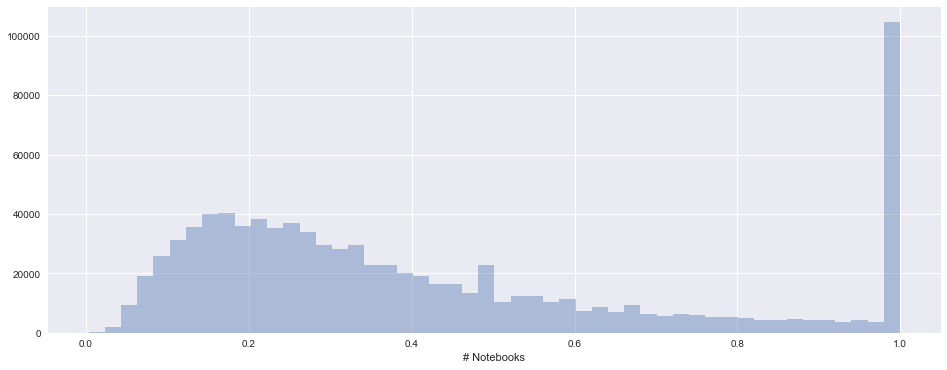

In [61]:
nb_words_ratio = df_nb_cell_max.num_words / df_nb_cell_counts.num_words
nb_words_ratio.dropna(inplace = True)
print('%s null values' % nb_words_ratio.isnull().sum())
print('%s nbs with words' % nb_words_ratio.shape[0])
print('%s nbs with all words in one cell' % nb_words_ratio[nb_words_ratio == 1].shape[0])
print('%s nbs with all words in one cell' % (nb_words_ratio[nb_words_ratio == 1].shape[0] / nb_words_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_words_ratio, 
                  kde=False)
ax.set_xlabel('Words notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
761957 nbs with comments
147787 nbs with all comments in one cell
0.1939571393136358 nbs with all comments in one cell
0


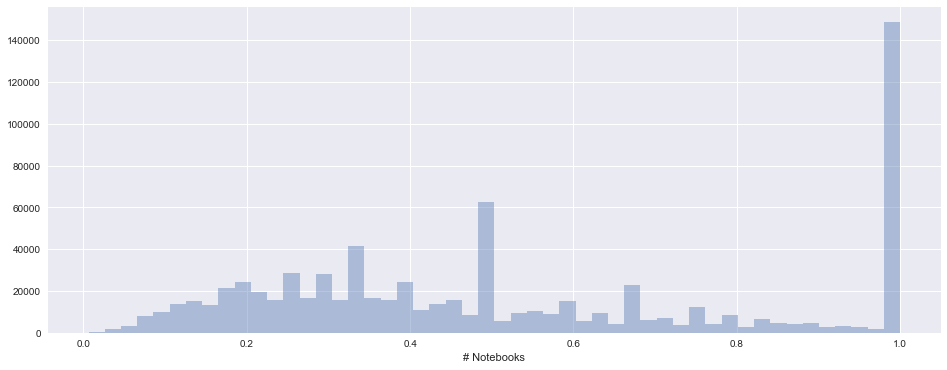

In [62]:
nb_comments_ratio = df_nb_cell_max.num_comment_lines / df_nb_cell_counts.num_comment_lines
nb_comments_ratio.dropna(inplace = True)
print('%s null values' % nb_comments_ratio.isnull().sum())
print('%s nbs with comments' % nb_comments_ratio.shape[0])
print('%s nbs with all comments in one cell' % nb_comments_ratio[nb_comments_ratio == 1].shape[0])
print('%s nbs with all comments in one cell' % (nb_comments_ratio[nb_comments_ratio == 1].shape[0] / nb_comments_ratio.shape[0]))
print(len(nb_comments_ratio[nb_comments_ratio > 1]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_comments_ratio[nb_comments_ratio <=1], 
                  kde=False)
ax.set_xlabel('comments notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
542378 nbs with functions
202248 nbs with all functions in one cell
0.37289123083900894 nbs with all functions in one cell


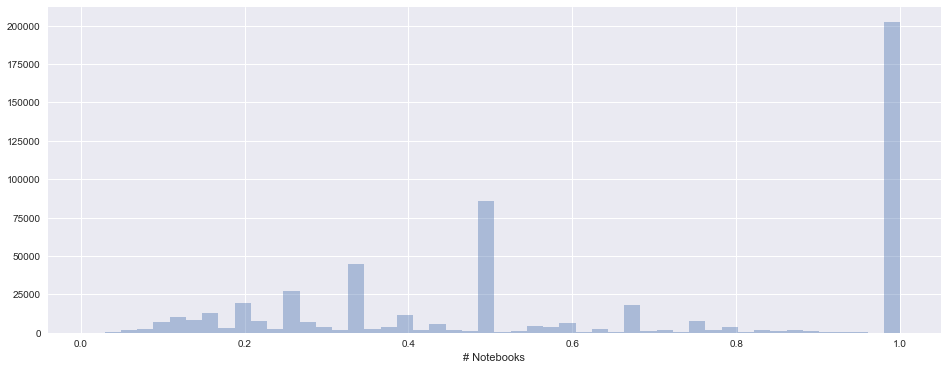

In [63]:
nb_functions_ratio = df_nb_cell_max.num_functions / df_nb_cell_counts.num_functions
nb_functions_ratio.dropna(inplace = True)
print('%s null values' % nb_functions_ratio.isnull().sum())
print('%s nbs with functions' % nb_functions_ratio.shape[0])
print('%s nbs with all functions in one cell' % nb_functions_ratio[nb_functions_ratio == 1].shape[0])
print('%s nbs with all functions in one cell' % (nb_functions_ratio[nb_functions_ratio == 1].shape[0] / nb_functions_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_functions_ratio, 
                  kde=False)
ax.set_xlabel('functions notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
919192 nbs with imports
434203 nbs with all imports in one cell
0.4723746507802505 nbs with all imports in one cell


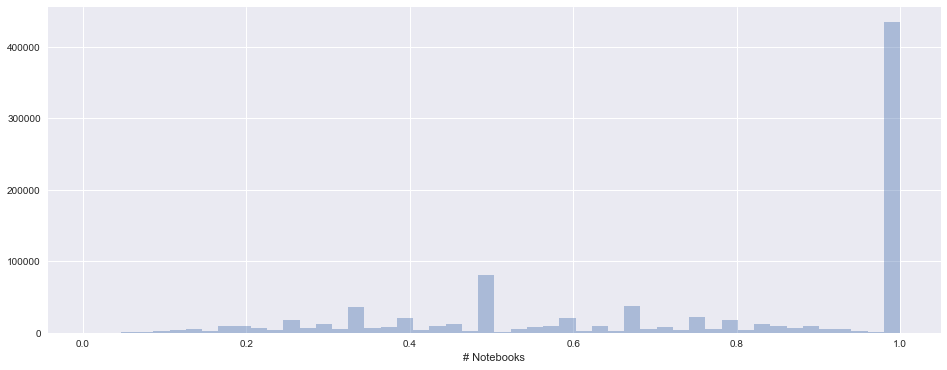

In [64]:
nb_imports_ratio = df_nb_cell_max.num_imports / df_nb_cell_counts.num_imports
nb_imports_ratio.dropna(inplace = True)
print('%s null values' % nb_imports_ratio.isnull().sum())
print('%s nbs with imports' % nb_imports_ratio.shape[0])
print('%s nbs with all imports in one cell' % nb_imports_ratio[nb_imports_ratio == 1].shape[0])
print('%s nbs with all imports in one cell' % (nb_imports_ratio[nb_imports_ratio == 1].shape[0] / nb_imports_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_imports_ratio, 
                  kde=False)
ax.set_xlabel('imports notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
123435 nbs with classes
72962 nbs with all classes in one cell
0.5910965285372868 nbs with all classes in one cell


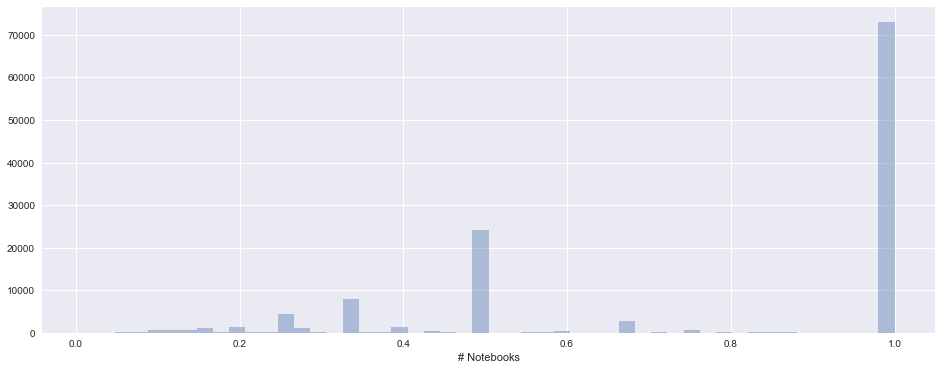

In [65]:
nb_classes_ratio = df_nb_cell_max.num_classes / df_nb_cell_counts.num_classes
nb_classes_ratio.dropna(inplace = True)
print('%s null values' % nb_classes_ratio.isnull().sum())
print('%s nbs with classes' % nb_classes_ratio.shape[0])
print('%s nbs with all classes in one cell' % nb_classes_ratio[nb_classes_ratio == 1].shape[0])
print('%s nbs with all classes in one cell' % (nb_classes_ratio[nb_classes_ratio == 1].shape[0] / nb_classes_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_classes_ratio, 
                  kde=False)
ax.set_xlabel('classes notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
387604 nbs with links
165626 nbs with all links in one cell
0.4273072517311483 nbs with all links in one cell


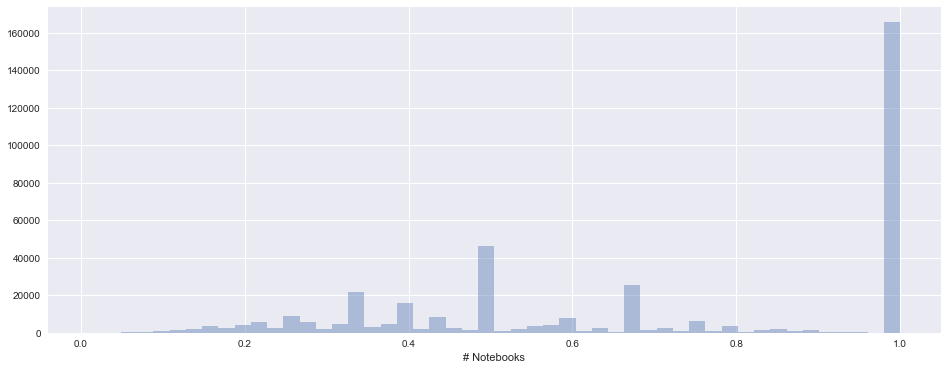

In [66]:
nb_links_ratio = df_nb_cell_max.num_links / df_nb_cell_counts.num_links
nb_links_ratio.dropna(inplace = True)
print('%s null values' % nb_links_ratio.isnull().sum())
print('%s nbs with links' % nb_links_ratio.shape[0])
print('%s nbs with all links in one cell' % nb_links_ratio[nb_links_ratio == 1].shape[0])
print('%s nbs with all links in one cell' % (nb_links_ratio[nb_links_ratio == 1].shape[0] / nb_links_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_links_ratio, 
                  kde=False)
ax.set_xlabel('links notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
738903 nbs with headers
148130 nbs with all headers in one cell
0.20047286314983156 nbs with all headers in one cell


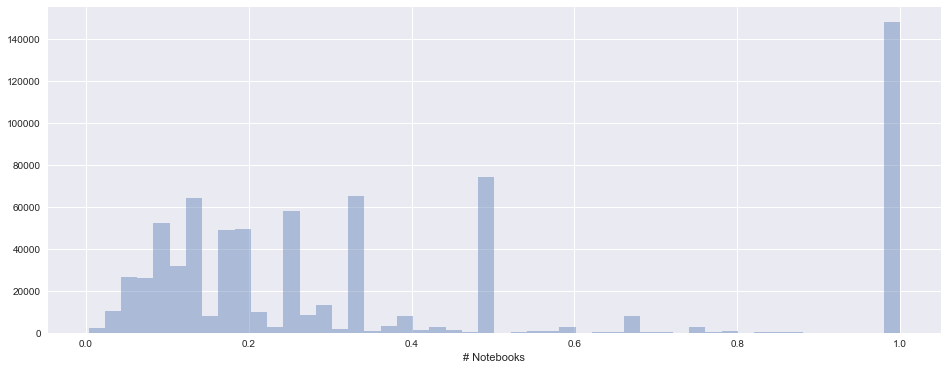

In [67]:
nb_headers_ratio = df_nb_cell_max.num_headers / df_nb_cell_counts.num_headers
nb_headers_ratio.dropna(inplace = True)
print('%s null values' % nb_headers_ratio.isnull().sum())
print('%s nbs with headers' % nb_headers_ratio.shape[0])
print('%s nbs with all headers in one cell' % nb_headers_ratio[nb_headers_ratio == 1].shape[0])
print('%s nbs with all headers in one cell' % (nb_headers_ratio[nb_headers_ratio == 1].shape[0] / nb_headers_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_headers_ratio, 
                  kde=False)
ax.set_xlabel('headers notebook in one cell')
ax.set_xlabel('# Notebooks')

# 7. Outputs

Again a similar analysis or where different types of outputs are in the notebook. Mainly I just looked at the % of all ntoebooks with each type of output.

0 null values
558365 nbs with display_data
143449 nbs with all display_data in one cell
0.256909011130712 nbs with all display_data in one cell


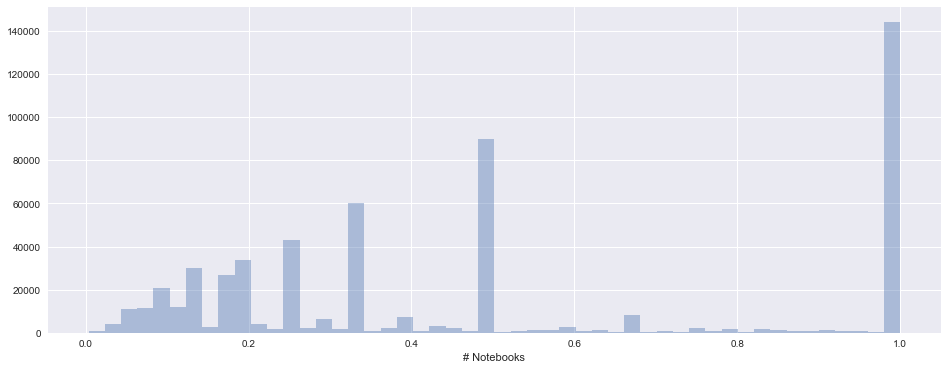

In [68]:
nb_display_data_ratio = df_nb_cell_max.num_display_data / df_nb_cell_counts.num_display_data
nb_display_data_ratio.dropna(inplace = True)
print('%s null values' % nb_display_data_ratio.isnull().sum())
print('%s nbs with display_data' % nb_display_data_ratio.shape[0])
print('%s nbs with all display_data in one cell' % nb_display_data_ratio[nb_display_data_ratio == 1].shape[0])
print('%s nbs with all display_data in one cell' % (nb_display_data_ratio[nb_display_data_ratio == 1].shape[0] / nb_display_data_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_display_data_ratio, 
                  kde=False)
ax.set_xlabel('display_data notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
713420 nbs with execute_result
145509 nbs with all execute_result in one cell
0.2039597992767234 nbs with all execute_result in one cell


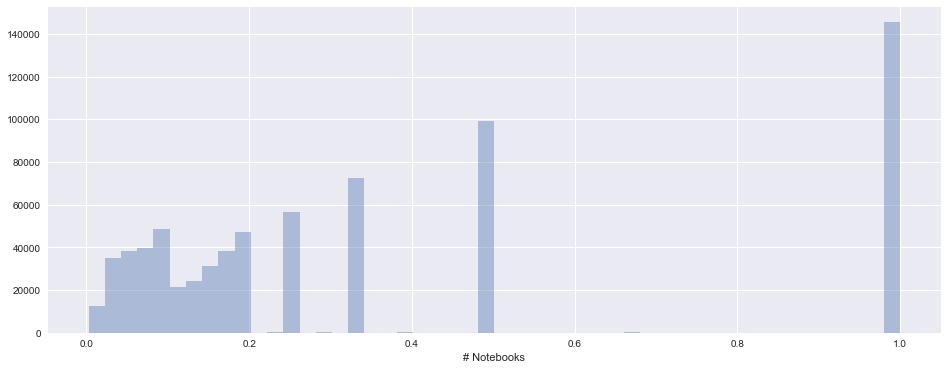

In [69]:
nb_execute_result_ratio = df_nb_cell_max.num_execute_result / df_nb_cell_counts.num_execute_result
nb_execute_result_ratio.dropna(inplace = True)
print('%s null values' % nb_execute_result_ratio.isnull().sum())
print('%s nbs with execute_result' % nb_execute_result_ratio.shape[0])
print('%s nbs with all execute_result in one cell' % nb_execute_result_ratio[nb_execute_result_ratio == 1].shape[0])
print('%s nbs with all execute_result in one cell' % (nb_execute_result_ratio[nb_execute_result_ratio == 1].shape[0] / nb_execute_result_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_execute_result_ratio, 
                  kde=False)
ax.set_xlabel('execute_result notebook in one cell')
ax.set_xlabel('# Notebooks')

0 null values
840549 nbs with stream
203012 nbs with all stream in one cell
0.24152309978359382 nbs with all stream in one cell


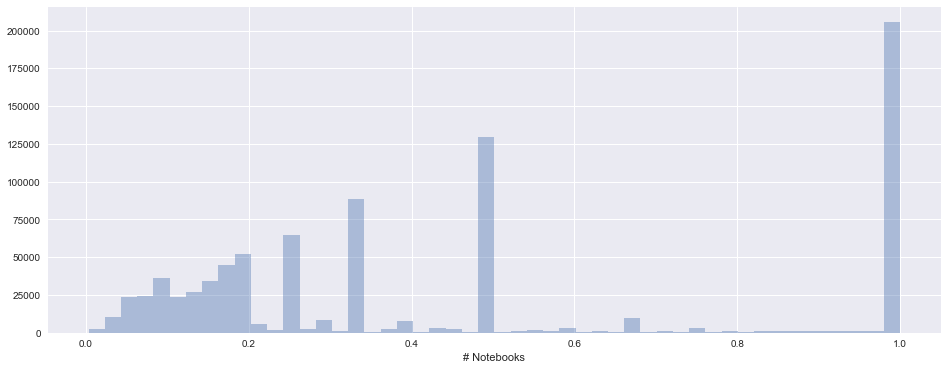

In [70]:
nb_stream_ratio = df_nb_cell_max.num_stream / df_nb_cell_counts.num_stream
nb_stream_ratio.dropna(inplace = True)
print('%s null values' % nb_stream_ratio.isnull().sum())
print('%s nbs with stream' % nb_stream_ratio.shape[0])
print('%s nbs with all stream in one cell' % nb_stream_ratio[nb_stream_ratio == 1].shape[0])
print('%s nbs with all stream in one cell' % (nb_stream_ratio[nb_stream_ratio == 1].shape[0] / nb_stream_ratio.shape[0]))

plt.figure(figsize=(16,6))
ax = sns.distplot(nb_stream_ratio, 
                  kde=False)
ax.set_xlabel('stream notebook in one cell')
ax.set_xlabel('# Notebooks')

## 7.1 Output Order

This is a litte messy, and took a wile, but this code checks if the order of outputs is linear (1, 2, 3, 4, ...) or if we have evidence for cells being run out of order. This took a while to run, so I won't re-run the analysis here as I clean the notebook.

The main finding is that nearly half (44%) of notebooks with outputs are run out of order (that is not stricly linearly)

In [13]:
output_order = []
count = 0

for i in df_nb_complete.nb_id:
    
    #track progress
    count += 1
    if count % 1000 == 0:
        print(count)
    
    execution_order = []
    
    # open file and get data
    with open('../data/notebooks/nb_%s.ipynb' % i, 'r') as nb_file:
        try:
            data = json.load(nb_file)
        except:
            print('had trouble loading nb %s' % i)
            continue

        if isinstance(data, dict): 
            keys = data.keys()
        else:
            keys = []
            
        # get data for each cell, nbformat v 4.x
        if 'cells' in keys:
            for i, c in enumerate(data['cells']):
                if isinstance(c, dict):
                    cell_keys = c.keys()
                else:
                    cell_keys = []
                
                if 'execution_count' in cell_keys:
                    if isinstance(c['execution_count'], int):
                        execution_order.append([i, int(c['execution_count'])])

        # get data for each cell, nbformat v 2.x / 3.x
        elif 'worksheets' in keys:
            for j, w in enumerate(data['worksheets']):
                if isinstance(w, dict): 
                    worksheet_keys = w.keys()
                else:
                    keys = []
                if 'cells' in worksheet_keys:
                    for k, c in enumerate(w['cells']):
                        if isinstance(c, dict):
                            cell_keys = c.keys()
                        else:
                            cell_keys = []
                        
                        if 'prompt_number' in cell_keys:
                            if isinstance(c['prompt_number'], int):
                                execution_order.append([i, int(c['prompt_number'])])
        output_order.append(execution_order)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

1164000
1165000
1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000


In [20]:
output_order_trimmed = [[c[1] for c in o] for o in output_order]

In [28]:
outputs_inorder = [all(l[i] <= l[i+1] for i in range(len(l)-1)) for l in output_order_trimmed]

In [29]:
np_inorder = np.array(outputs_inorder)

In [33]:
df_order = pd.DataFrame(np_inorder)
df_order.columns = ['inorder']
df_order['inorder'].value_counts()

True     753797
False    473776
Name: inorder, dtype: int64

In [41]:
empty_order = [len(l) > 0 for l in output_order_trimmed]

In [42]:
df_empty_order = pd.DataFrame(empty_order)
df_empty_order.columns = ['empty']
df_empty_order['empty'].value_counts()

True     1079892
False     147681
Name: empty, dtype: int64

Let's see what percent of notebooks with output are in order, or out of order.

In [43]:
(753797 - 147681) / (1227573 - 147681)

0.5612746459831168

# 8.0 Cells

- There are 34,690,935 cells in the notebooks
- 22,318,687 of these are code cells (~ 2/3)
- about 1/2 of code cells have no output
- about 20% have a computed result
- about 10% have a graphical result

In [71]:
print('%s total markdown + raw cells' % df_cell_complete[df_cell_complete.cell_type != 'code'].shape[0])
print('%s total code cells' % df_cell_complete[df_cell_complete.cell_type == 'code'].shape[0])
print('%s cells with no output' % df_cell_complete[(df_cell_complete.cell_type == 'code') & (df_cell_complete.num_error + df_cell_complete.num_stream + df_cell_complete.num_display_data + df_cell_complete.num_execute_result == 0)].shape[0])
print('%s cells with a stream result' % df_cell_complete[df_cell_complete.num_stream > 0].shape[0])
print('%s cells with a computed result' % df_cell_complete[df_cell_complete.num_execute_result > 0].shape[0])
print('%s cells with a graphical result' % df_cell_complete[df_cell_complete.num_display_data > 0].shape[0])
print('%s cells with error' % df_cell_complete[df_cell_complete.num_error > 0].shape[0])

12259551 total markdown + raw cells
22226817 total code cells
10565406 cells with no output
4626347 cells with a stream result
5740318 cells with a computed result
2731430 cells with a graphical result
290464 cells with error


## 8.1 Displayed Items

In [73]:
import ast
all_display_keys = {}
cells_with_display_keys = {}

for i, v in df_cell_complete.display_data_keys.iteritems():

    if i % 5000000 == 0:
        print(i)
    
    keys = all_display_keys.keys()
    vl = ast.literal_eval(v)
    for k in vl:
        if k in keys:
            all_display_keys[k] += 1
        else:
            all_display_keys[k] = 1
    
    cell_keys = cells_with_display_keys.keys()
    unique_keys = list(set(vl))
    for k in unique_keys:
        if k in cell_keys:
            cells_with_display_keys[k] += 1
        else:
            cells_with_display_keys[k] = 1    

0
5000000
10000000
15000000
20000000


KeyboardInterrupt: 

### Total number Graphical text and image outputs by type (cells can have more than one of each type, i.e. multiple graphs in one cell)

In [38]:
display_keys_list = [[all_display_keys[v], v] for k,v in enumerate(all_display_keys)]
display_keys_list.sort(key=lambda x: x[0], reverse=True)
display_keys_list = display_keys_list[0:10]

dv = [i[0] for i in display_keys_list]
dk = [i[1] for i in display_keys_list]

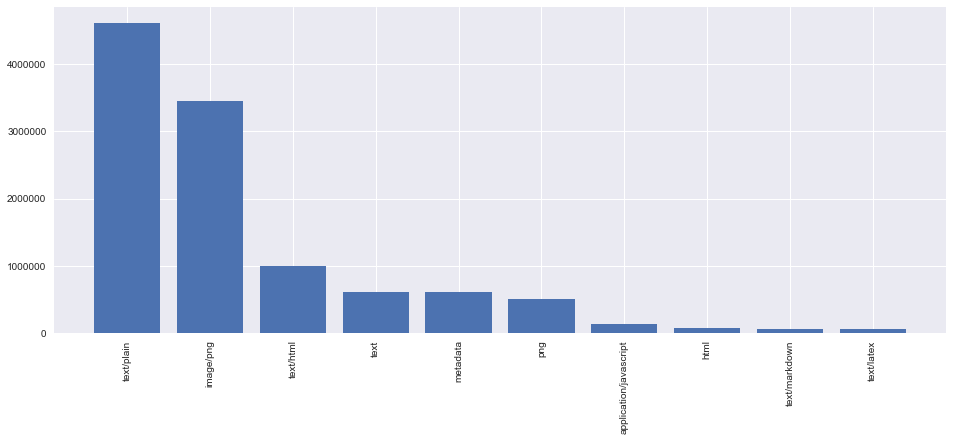

In [238]:
plt.figure(figsize=(16,6))
plt.bar(range(len(dv)), dv, align='center')
plt.xticks(range(len(dv)), dk, rotation='vertical')

plt.show()

### Number of Graphical Cells with each type of output

In [248]:
cell_display_keys_list = [[cells_with_display_keys[v], v] for k,v in enumerate(cells_with_display_keys)]
cell_display_keys_list.sort(key=lambda x: x[0], reverse=True)
cell_display_keys_list = cell_display_keys_list[0:10]

cdv = [i[0] for i in cell_display_keys_list]
cdk = [i[1] for i in cell_display_keys_list]

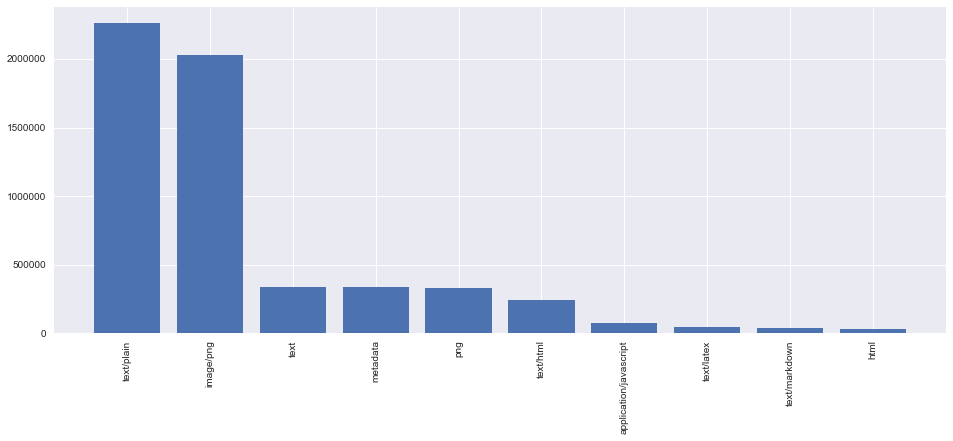

In [249]:
plt.figure(figsize=(16,6))
plt.bar(range(len(cdv)), cdv, align='center')
plt.xticks(range(len(cdv)), cdk, rotation='vertical')

plt.show()

# 8.2 Executed Items

In [246]:
all_result_keys = {}
cells_with_result_keys = {}

for i, v in df_cell_complete.execute_result_keys.iteritems():

    if i % 5000000 == 0:
        print(i)
    
    keys = all_result_keys.keys()
    vl = ast.literal_eval(v)
    for k in vl:
        if k in keys:
            all_result_keys[k] += 1
        else:
            all_result_keys[k] = 1
            
    cell_keys = cells_with_result_keys.keys()
    unique_keys = list(set(vl))
    for k in unique_keys:
        if k in cell_keys:
            cells_with_result_keys[k] += 1
        else:
            cells_with_result_keys[k] = 1 

0
5000000
10000000
15000000
20000000
25000000
30000000


### Total number of execution results, by type

In [41]:
result_keys_list = [[all_result_keys[v], v] for k,v in enumerate(all_result_keys)]
result_keys_list.sort(key=lambda x: x[0], reverse=True)
result_keys_list = result_keys_list[0:10]

rv = [i[0] for i in result_keys_list]
rk = [i[1] for i in result_keys_list]

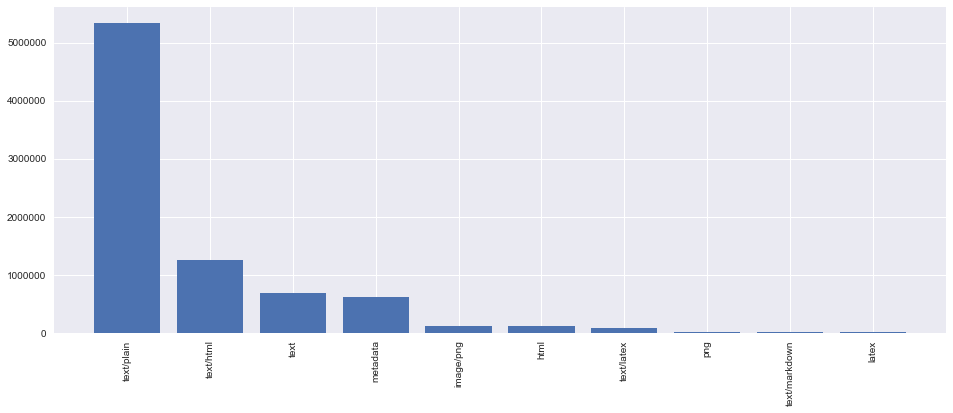

In [239]:
plt.figure(figsize=(16,6))
plt.bar(range(len(rk)), rv, align='center')
plt.xticks(range(len(rk)), list(rk),rotation='vertical')

plt.show()

### Number of cells with each each executed item type

In [286]:
cell_result_keys_list = [[cells_with_result_keys[v], v] for k,v in enumerate(cells_with_result_keys)]
cell_result_keys_list.sort(key=lambda x: x[0], reverse=True)
cell_result_keys_list = cell_result_keys_list[0:10]

crv = [i[0] for i in cell_result_keys_list]
crk = [i[1] for i in cell_result_keys_list]

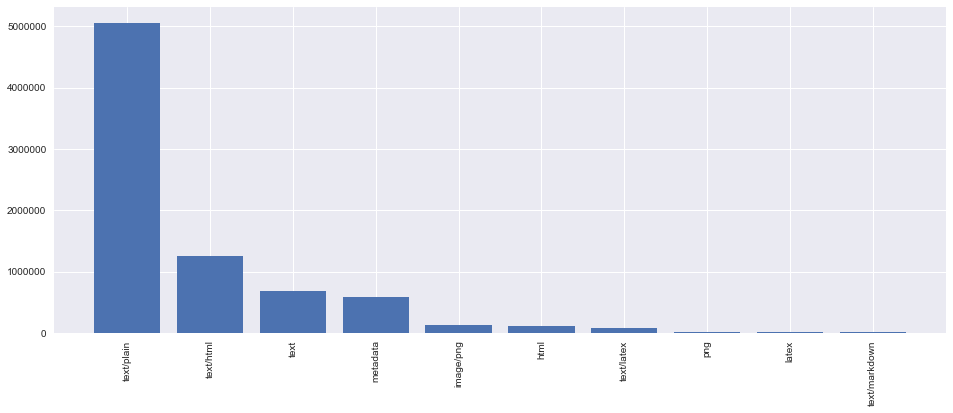

In [287]:
plt.figure(figsize=(16,6))
plt.bar(range(len(crv)), crv, align='center')
plt.xticks(range(len(crv)), crk, rotation='vertical')

plt.show()

# 9. Forked Repositories

Finally, we looked at if notebooks in repos that had been forked differed systematicaly in those in repos that had note been forked. In the end we dropped this analysis as there are a number of other potetnially confounding factoers such as that a repo may be mostly documeing a software package and not about the notebooks, so any effect we see may be due to the imapct and organization of the software package, note the notebooks themselves. 


- the vast majority of repos are never forked, only 1/6 have been forked at all

In [271]:
df_repo_nb_size = df_nb_complete[['repo_id', 'size']].groupby('repo_id').agg('sum')

In [275]:
df_repo_nb_size.columns = ['nb_size']
df_repo_nb_size['id'] = df_repo_nb_size.index

In [276]:
df_repo_complete = df_repo_complete.merge(
    df_repo_nb_size,
    how = 'left',
    on = 'id'
)

## 9.1 Number of Forked Repositories and Notebooks

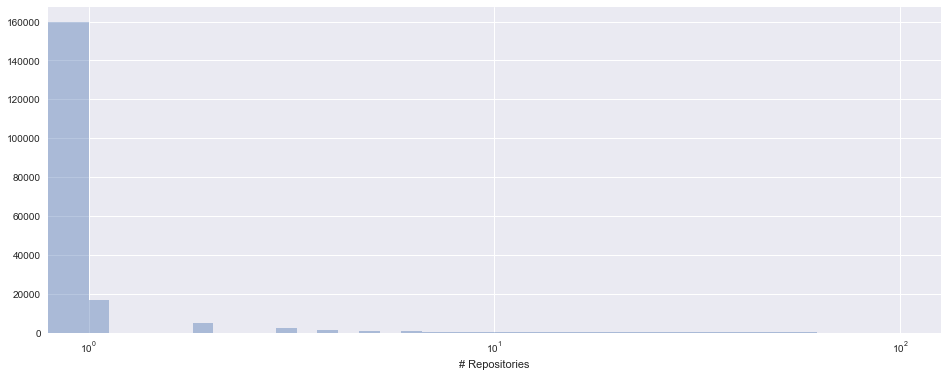

In [254]:
plt.figure(figsize=(16,6))
ax = sns.distplot(df_repo_complete.forks_count, kde=False, bins = np.append(0, np.logspace(0,2,40)))
ax.set_xscale('log')
ax.set_xlabel('Forks per repository')
ax.set_xlabel('# Repositories')

In [355]:
unforked_nbs = df_nb_complete[~df_nb_complete.repo_id.isin(forked_repos)]
print('%s repositoires have not been forked' % df_repo_complete[df_repo_complete.forks_count == 0].shape[0])
print('%s notbooks have not been forked' % unforked_nbs.shape[0])

159718 repositoires have not been forked
934165 notbooks have not been forked


In [357]:
forked_repos = df_repo_complete[df_repo_complete.forks_count > 0]['id']
forked_nbs = df_nb_complete[df_nb_complete.repo_id.isin(forked_repos)]
print('%s repositoires have been forked' % df_repo_complete[df_repo_complete.forks_count > 0].shape[0])
print('%s notbooks have been forked' % forked_nbs.shape[0])

33308 repositoires have been forked
302429 notbooks have been forked


In [352]:
forked_repos_10 = df_repo_complete[df_repo_complete.forks_count > 9]['id']
forked_nbs_10 = df_nb_complete[df_nb_complete.repo_id.isin(forked_repos_10)]
forked_df_cell_counts_10 = forked_df_cell_counts[forked_df_cell_counts.index.isin(forked_nbs_10.nb_id)]
print('%s repositoires have been forked 10 or more times' % df_repo_complete[df_repo_complete.forks_count > 9].shape[0])
print('%s notbooks have been forked 10 or more time' % forked_nbs_10.shape[0])

69572 notbooks have been forked 10 or more time


In [358]:
forked_repos_100 = df_repo_complete[df_repo_complete.forks_count > 99]['id']
forked_nbs_100 = df_nb_complete[df_nb_complete.repo_id.isin(forked_repos_100)]
forked_df_cell_counts_100 = forked_df_cell_counts[forked_df_cell_counts.index.isin(forked_nbs_100.nb_id)]
print('%s repositoires have been forked 100 or more times' % df_repo_complete[df_repo_complete.forks_count > 99].shape[0])
print('%s notbooks have been forked 10 or more time' % forked_nbs_100.shape[0])

536 repositoires have been forked 100 or more times
10666 notbooks have been forked 10 or more time


## 9.2 Comparing Cells in Forked and UnForked Repositiories

In [297]:
forked_cells = df_cell_complete[df_cell_complete.nb_id.isin(forked_nbs.nb_id)]

forked_num_cells = forked_cells[['cell_index', 'nb_id']].groupby('nb_id').count()
forked_num_cells.columns= ['num_cells']

forked_num_markdown = forked_cells[['cell_type', 'nb_id']][forked_cells.cell_type != 'code'].groupby('nb_id').count()
forked_num_markdown.columns = ['num_markdown_cells']

forked_num_code = forked_cells[['cell_type', 'nb_id']][forked_cells.cell_type == 'code'].groupby('nb_id').count()
forked_num_code.columns = ['num_code_cells']

forked_total_words = forked_cells[['num_words', 'nb_id']].groupby('nb_id')['num_words'].sum()
forked_total_words = pd.DataFrame(forked_total_words)

forked_total_links = forked_cells[['num_links', 'nb_id']].groupby('nb_id')['num_links'].sum()
forked_total_links = pd.DataFrame(forked_total_links)

forked_total_headers = forked_cells[['num_headers', 'nb_id']].groupby('nb_id')['num_headers'].sum()
forked_total_headers = pd.DataFrame(forked_total_headers)

forked_total_imports = forked_cells[['num_imports', 'nb_id']].groupby('nb_id')['num_imports'].sum()
forked_total_imports = pd.DataFrame(forked_total_imports)

forked_total_loc = forked_cells[['lines_of_code', 'nb_id']].groupby('nb_id')['lines_of_code'].sum()
forked_total_loc = pd.DataFrame(forked_total_loc)

In [298]:
forked_df_cell_counts = None
forked_df_cell_counts = forked_num_cells.merge(forked_num_markdown, how='outer', left_index=True, right_index=True)
forked_df_cell_counts = forked_df_cell_counts.merge(forked_num_code, how='outer', left_index=True, right_index=True)
forked_df_cell_counts = forked_df_cell_counts.merge(forked_total_words, how='outer', left_index=True, right_index=True)
forked_df_cell_counts = forked_df_cell_counts.merge(forked_total_links, how='outer', left_index=True, right_index=True)
forked_df_cell_counts = forked_df_cell_counts.merge(forked_total_headers, how='outer', left_index=True, right_index=True)
forked_df_cell_counts = forked_df_cell_counts.merge(forked_total_imports, how='outer', left_index=True, right_index=True)
forked_df_cell_counts = forked_df_cell_counts.merge(forked_total_loc, how='outer', left_index=True, right_index=True)
forked_df_cell_counts = forked_df_cell_counts.fillna(0)
forked_df_cell_counts.head()

,num_cells,num_markdown_cells,num_code_cells,num_words,num_links,num_headers,num_imports,lines_of_code
nb_id,,,,,,,,
593,94,0.0,94.0,0.0,0,0,11,751.0
594,45,2.0,43.0,171.0,1,7,1,44.0
605,12,7.0,5.0,562.0,0,2,8,98.0
606,12,7.0,5.0,562.0,0,2,8,98.0
610,11,1.0,10.0,11.0,0,0,10,215.0


In [299]:
unforked_cells = df_cell_complete[df_cell_complete.nb_id.isin(unforked_nbs.nb_id)]

unforked_num_cells = unforked_cells[['cell_index', 'nb_id']].groupby('nb_id').count()
unforked_num_cells.columns= ['num_cells']

unforked_num_markdown = unforked_cells[['cell_type', 'nb_id']][unforked_cells.cell_type != 'code'].groupby('nb_id').count()
unforked_num_markdown.columns = ['num_markdown_cells']

unforked_num_code = unforked_cells[['cell_type', 'nb_id']][unforked_cells.cell_type == 'code'].groupby('nb_id').count()
unforked_num_code.columns = ['num_code_cells']

unforked_total_words = unforked_cells[['num_words', 'nb_id']].groupby('nb_id')['num_words'].sum()
unforked_total_words = pd.DataFrame(unforked_total_words)

unforked_total_links = unforked_cells[['num_links', 'nb_id']].groupby('nb_id')['num_links'].sum()
unforked_total_links = pd.DataFrame(unforked_total_links)

unforked_total_headers = unforked_cells[['num_headers', 'nb_id']].groupby('nb_id')['num_headers'].sum()
unforked_total_headers = pd.DataFrame(unforked_total_headers)

unforked_total_imports = unforked_cells[['num_imports', 'nb_id']].groupby('nb_id')['num_imports'].sum()
unforked_total_imports = pd.DataFrame(unforked_total_imports)

unforked_total_loc = unforked_cells[['lines_of_code', 'nb_id']].groupby('nb_id')['lines_of_code'].sum()
unforked_total_loc = pd.DataFrame(unforked_total_loc)

In [301]:
unforked_df_cell_counts = None
unforked_df_cell_counts = unforked_num_cells.merge(unforked_num_markdown, how='outer', left_index=True, right_index=True)
unforked_df_cell_counts = unforked_df_cell_counts.merge(unforked_num_code, how='outer', left_index=True, right_index=True)
unforked_df_cell_counts = unforked_df_cell_counts.merge(unforked_total_words, how='outer', left_index=True, right_index=True)
unforked_df_cell_counts = unforked_df_cell_counts.merge(unforked_total_links, how='outer', left_index=True, right_index=True)
unforked_df_cell_counts = unforked_df_cell_counts.merge(unforked_total_headers, how='outer', left_index=True, right_index=True)
unforked_df_cell_counts = unforked_df_cell_counts.merge(unforked_total_imports, how='outer', left_index=True, right_index=True)
unforked_df_cell_counts = unforked_df_cell_counts.merge(unforked_total_loc, how='outer', left_index=True, right_index=True)
unforked_df_cell_counts = unforked_df_cell_counts.fillna(0)
unforked_df_cell_counts.head()

,num_cells,num_markdown_cells,num_code_cells,num_words,num_links,num_headers,num_imports,lines_of_code
nb_id,,,,,,,,
585,34,19.0,15.0,1687.0,1,18,4,597.0
586,23,6.0,17.0,355.0,2,3,3,215.0
587,42,2.0,40.0,2.0,0,0,23,346.0
588,10,0.0,10.0,0.0,0,0,16,355.0
589,30,10.0,20.0,337.0,0,9,7,78.0


### All Cells

Median 18.0 cells per unforked notebook
Median 19.0 cells per forked notebook
Median 19.0 cells per notebook forked 10+ times
Median 14.0 cells per notebook forked 100+ times
Ttest_indResult(statistic=-26.535302930337977, pvalue=4.1968539941436253e-155)


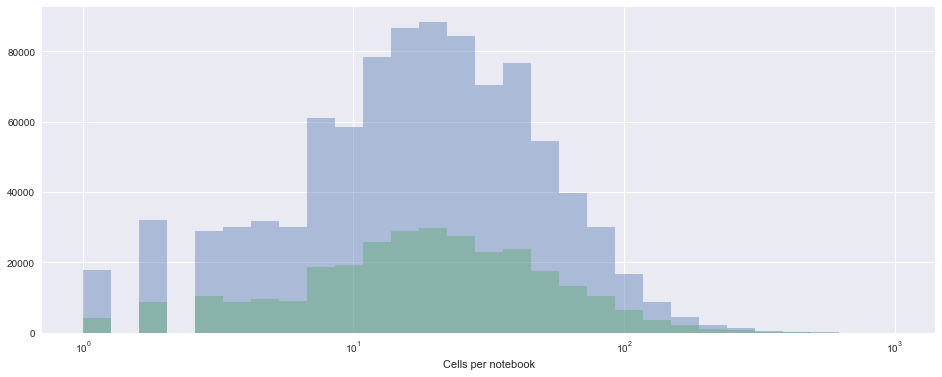

In [333]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.num_cells, kde=False, ax=ax, bins = np.append(0, np.logspace(0,3,30)))
sns.distplot(forked_df_cell_counts.num_cells, kde=False, ax=ax, bins = np.append(0, np.logspace(0,3,30)))

ax.set_xscale('log')
ax.set_xlabel('Cells per notebook')

print('Median %s cells per unforked notebook' % unforked_df_cell_counts.num_cells.median())
print('Median %s cells per forked notebook' % forked_df_cell_counts.num_cells.median())
print('Median %s cells per notebook forked 10+ times' % forked_df_cell_counts_10.num_cells.median())
print('Median %s cells per notebook forked 100+ times' % forked_df_cell_counts_100.num_cells.median())
print(ttest_ind(unforked_df_cell_counts.num_cells, forked_df_cell_counts.num_cells))

### Markdown Cells

Median 4.0 markdown cells per unforked notebook
Median 6.0 markdown cells per forked notebook
Median 8.0 markdown cells per notebook forked 10+ times
Median 6.0 markdown cells per notebook forked 100+ times
Ttest_indResult(statistic=-53.818407447588456, pvalue=0.0)

Removing Notebooks with no markdown at all
Median 8.0 markdown cells per unforked notebook
Median 9.0 markdown cells per forked notebook
Median 9.0 markdown cells per notebook forked 10+ times
Median 8.0 markdown cells per notebook forked 100+ times
Ttest_indResult(statistic=-27.868913992921733, pvalue=7.5257342147593739e-171)


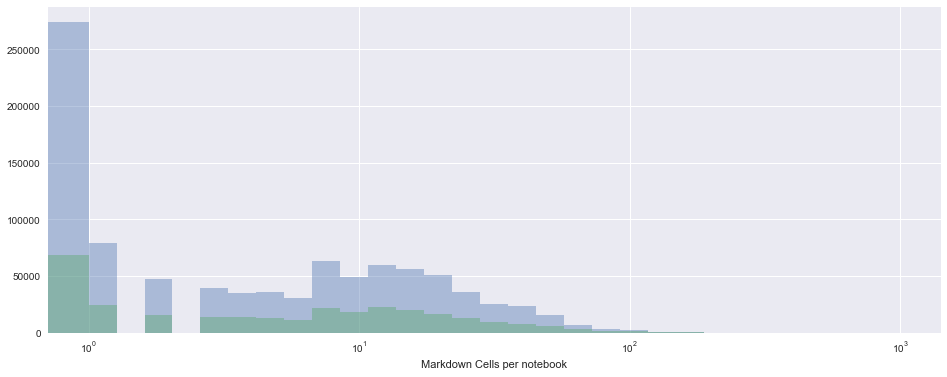

In [338]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.num_markdown_cells, kde=False, ax=ax, bins = np.append(0, np.logspace(0,3,30)))
sns.distplot(forked_df_cell_counts.num_markdown_cells, kde=False, ax=ax, bins = np.append(0, np.logspace(0,3,30)))

ax.set_xscale('log')
ax.set_xlabel('Markdown Cells per notebook')

print('Median %s markdown cells per unforked notebook' % unforked_df_cell_counts.num_markdown_cells.median())
print('Median %s markdown cells per forked notebook' % forked_df_cell_counts.num_markdown_cells.median())
print('Median %s markdown cells per notebook forked 10+ times' % forked_df_cell_counts_10.num_markdown_cells.median())
print('Median %s markdown cells per notebook forked 100+ times' % forked_df_cell_counts_100.num_markdown_cells.median())
print(ttest_ind(unforked_df_cell_counts.num_markdown_cells, forked_df_cell_counts.num_markdown_cells))
print('')
print('Removing Notebooks with no markdown at all')
print('Median %s markdown cells per unforked notebook' % unforked_df_cell_counts[unforked_df_cell_counts.num_markdown_cells > 0].num_markdown_cells.median())
print('Median %s markdown cells per forked notebook' % forked_df_cell_counts[forked_df_cell_counts.num_markdown_cells > 0].num_markdown_cells.median())
print('Median %s markdown cells per notebook forked 10+ times' % forked_df_cell_counts_10[forked_df_cell_counts_10.num_markdown_cells > 0].num_markdown_cells.median())
print('Median %s markdown cells per notebook forked 100+ times' % forked_df_cell_counts_100[forked_df_cell_counts_100.num_markdown_cells > 0].num_markdown_cells.median())
print(ttest_ind(unforked_df_cell_counts[unforked_df_cell_counts.num_markdown_cells > 0].num_markdown_cells, forked_df_cell_counts[forked_df_cell_counts.num_markdown_cells > 0].num_markdown_cells))


### Code Cells

Median 12.0 code cells per unforked notebook
Median 12.0 code cells per forked notebook
Ttest_indResult(statistic=-0.11391301666319649, pvalue=0.90930676542445754)

Removing Notebooks with no markdown at all
Median 12.0 code cells per unforked notebook
Median 12.0 code cells per forked notebook
Median 11.0 code cells per notebook forked 10+ times
Median 8.0 code cells per notebook forked 100+ times
Ttest_indResult(statistic=-2.372525662365879, pvalue=0.0176670913161549)


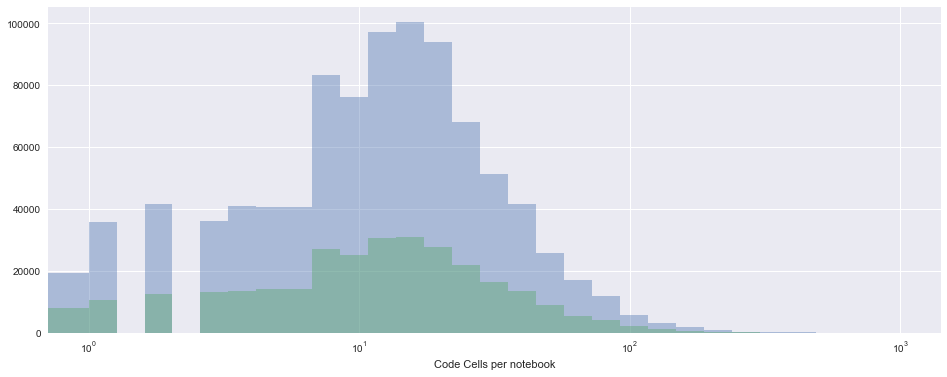

In [339]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.num_code_cells, kde=False, ax=ax, bins = np.append(0, np.logspace(0,3,30)))
sns.distplot(forked_df_cell_counts.num_code_cells, kde=False, ax=ax, bins = np.append(0, np.logspace(0,3,30)))

ax.set_xscale('log')
ax.set_xlabel('Code Cells per notebook')

print('Median %s code cells per unforked notebook' % unforked_df_cell_counts.num_code_cells.median())
print('Median %s code cells per forked notebook' % forked_df_cell_counts.num_code_cells.median())
print(ttest_ind(unforked_df_cell_counts.num_code_cells, forked_df_cell_counts.num_code_cells))
print('')
print('Removing Notebooks with no markdown at all')
print('Median %s code cells per unforked notebook' % unforked_df_cell_counts[unforked_df_cell_counts.num_code_cells > 0].num_code_cells.median())
print('Median %s code cells per forked notebook' % forked_df_cell_counts[forked_df_cell_counts.num_code_cells > 0].num_code_cells.median())
print('Median %s code cells per notebook forked 10+ times' % forked_df_cell_counts_10[forked_df_cell_counts_10.num_code_cells > 0].num_code_cells.median())
print('Median %s code cells per notebook forked 100+ times' % forked_df_cell_counts_100[forked_df_cell_counts_100.num_code_cells > 0].num_code_cells.median())
print(ttest_ind(unforked_df_cell_counts[unforked_df_cell_counts.num_code_cells > 0].num_code_cells, forked_df_cell_counts[forked_df_cell_counts.num_code_cells > 0].num_code_cells))


### Words per Notebook

Median 67.0 words per unforked notebook
Median 98.0 words per forked notebook
Median 115.0 words per notebook forked 10+ times
Median 115.0 words per notebook forked 100+ times
Ttest_indResult(statistic=-17.296145605631644, pvalue=5.121745976545979e-67)

Removing Notebooks with no markdown at all
Median 218.0 words per unforked notebook
Median 218.0 words per forked notebook
Median 173.0 words per notebook forked 10+ times
Median 167.0 words per notebook forked 100+ times
Ttest_indResult(statistic=5.073083427080717, pvalue=3.91499115775571e-07)


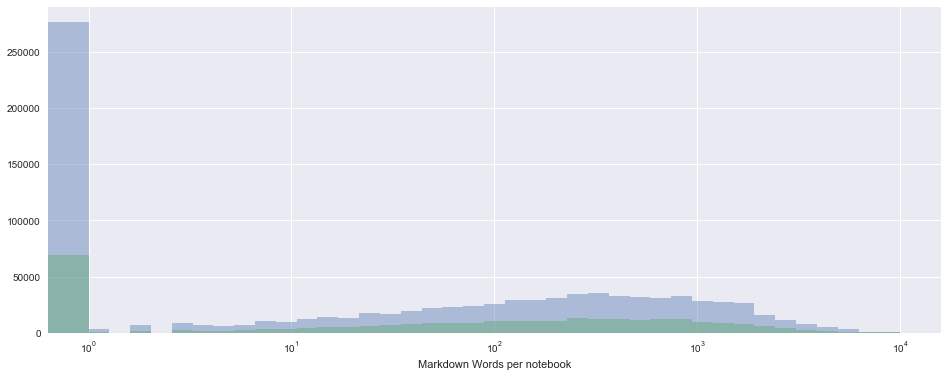

In [341]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.num_words, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))
sns.distplot(forked_df_cell_counts.num_words, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))

ax.set_xscale('log')
ax.set_xlabel('Markdown Words per notebook')

print('Median %s words per unforked notebook' % unforked_df_cell_counts.num_words.median())
print('Median %s words per forked notebook' % forked_df_cell_counts.num_words.median())
print('Median %s words per notebook forked 10+ times' % forked_df_cell_counts_10.num_words.median())
print('Median %s words per notebook forked 100+ times' % forked_df_cell_counts_100.num_words.median())
print(ttest_ind(unforked_df_cell_counts.num_words, forked_df_cell_counts.num_words))
print('')
print('Removing Notebooks with no markdown at all')
print('Median %s words per unforked notebook' % unforked_df_cell_counts[unforked_df_cell_counts.num_words > 0].num_words.median())
print('Median %s words per forked notebook' % forked_df_cell_counts.num_words[forked_df_cell_counts.num_words > 0].median())
print('Median %s words per notebook forked 10+ times' % forked_df_cell_counts_10.num_words[forked_df_cell_counts_10.num_words > 0].median())
print('Median %s words per notebook forked 100+ times' % forked_df_cell_counts_100.num_words[forked_df_cell_counts_100.num_words > 0].median())
print(ttest_ind(unforked_df_cell_counts[unforked_df_cell_counts.num_words > 0].num_words, forked_df_cell_counts[forked_df_cell_counts.num_words > 0].num_words))


### Code per Cell

Median 80.0 lines of code per unforked notebook
Median 78.0 lines of code per forked notebook
Median 75.0 lines of code per notebook forked 10+ times
Median 48.0 lines of code per notebook forked 100+ times
Ttest_indResult(statistic=2.6575523009998139, pvalue=0.0078711387960686326)

Removing Notebooks with no code at all
Median 85.0 lines of code per unforked notebook
Median 84.0 lines of code per forked notebook
Median 81.0 lines of code per notebook forked 10+ times
Median 51.0 lines of code per notebook forked 100+ times
Ttest_indResult(statistic=0.95009904966224901, pvalue=0.342062120529535)


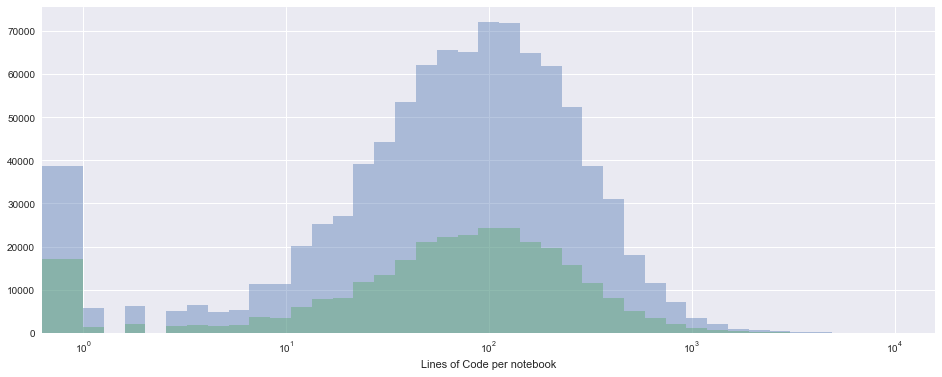

In [342]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.lines_of_code, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))
sns.distplot(forked_df_cell_counts.lines_of_code, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))

ax.set_xscale('log')
ax.set_xlabel('Lines of Code per notebook')

print('Median %s lines of code per unforked notebook' % unforked_df_cell_counts.lines_of_code.median())
print('Median %s lines of code per forked notebook' % forked_df_cell_counts.lines_of_code.median())
print('Median %s lines of code per notebook forked 10+ times' % forked_df_cell_counts_10.lines_of_code.median())
print('Median %s lines of code per notebook forked 100+ times' % forked_df_cell_counts_100.lines_of_code.median())
print(ttest_ind(unforked_df_cell_counts.lines_of_code, forked_df_cell_counts.lines_of_code))
print('')
print('Removing Notebooks with no code at all')
print('Median %s lines of code per unforked notebook' % unforked_df_cell_counts[unforked_df_cell_counts.lines_of_code > 0].lines_of_code.median())
print('Median %s lines of code per forked notebook' % forked_df_cell_counts.lines_of_code[forked_df_cell_counts.lines_of_code > 0].median())
print('Median %s lines of code per notebook forked 10+ times' % forked_df_cell_counts_10.lines_of_code[forked_df_cell_counts_10.lines_of_code > 0].median())
print('Median %s lines of code per notebook forked 100+ times' % forked_df_cell_counts_100.lines_of_code[forked_df_cell_counts_100.lines_of_code > 0].median())
print(ttest_ind(unforked_df_cell_counts[unforked_df_cell_counts.lines_of_code > 0].lines_of_code, forked_df_cell_counts[forked_df_cell_counts.lines_of_code > 0].lines_of_code))


### Num Links

Median 0.0 Links per unforked notebook
Median 0.0 Links per forked notebook
Median 0.0 Links per notebook forked 10+ times
Median 1.0 Links per notebook forked 100+ times
Ttest_indResult(statistic=-40.619237155356629, pvalue=0.0)

Removing Notebooks with no links at all
Median 4.0 Links per unforked notebook
Median 4.0 Links per forked notebook
Median 5.0 Links per notebook forked 10+ times
Median 6.0 Links per notebook forked 100+ times
Ttest_indResult(statistic=-14.832252320746987, pvalue=9.3546296803766039e-50)


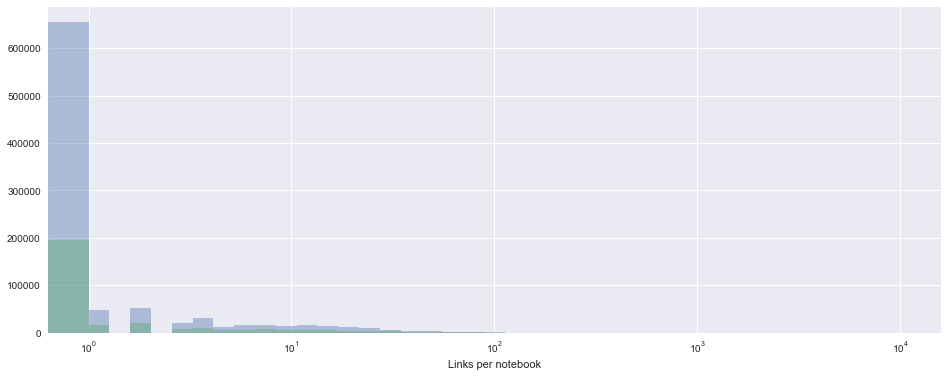

In [346]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.num_links, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))
sns.distplot(forked_df_cell_counts.num_links, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))

ax.set_xscale('log')
ax.set_xlabel('Links per notebook')

print('Median %s Links per unforked notebook' % unforked_df_cell_counts.num_links.median())
print('Median %s Links per forked notebook' % forked_df_cell_counts.num_links.median())
print('Median %s Links per notebook forked 10+ times' % forked_df_cell_counts_10.num_links.median())
print('Median %s Links per notebook forked 100+ times' % forked_df_cell_counts_100.num_links.median())
print(ttest_ind(unforked_df_cell_counts.num_links, forked_df_cell_counts.num_links))
print('')
print('Removing Notebooks with no links at all')
print('Median %s Links per unforked notebook' % unforked_df_cell_counts[unforked_df_cell_counts.num_links > 0].num_links.median())
print('Median %s Links per forked notebook' % forked_df_cell_counts.num_links[forked_df_cell_counts.num_links > 0].median())
print('Median %s Links per notebook forked 10+ times' % forked_df_cell_counts_10.num_links[forked_df_cell_counts_10.num_links > 0].median())
print('Median %s Links per notebook forked 100+ times' % forked_df_cell_counts_100.num_links[forked_df_cell_counts_100.num_links > 0].median())
print(ttest_ind(unforked_df_cell_counts[unforked_df_cell_counts.num_links > 0].num_links, forked_df_cell_counts[forked_df_cell_counts.num_links > 0].num_links))


### Headers

Median 1.0 headers per unforked notebook
Median 2.0 headers per forked notebook
Median 4.0 headers per notebook forked 10+ times
Median 3.0 headers per notebook forked 100+ times
Ttest_indResult(statistic=358.70518057037754, pvalue=0.0)

Removing Notebooks with no markdown at all
Median 5.0 headers per unforked notebook
Median 5.0 headers per forked notebook
Median 6.0 headers per notebook forked 10+ times
Median 4.0 headers per notebook forked 100+ times
Ttest_indResult(statistic=-0.77357869073785424, pvalue=0.43918022561470293)


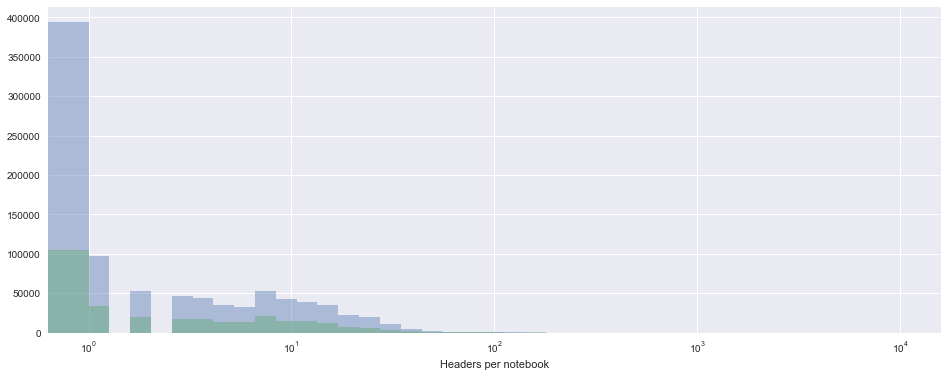

In [348]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.num_headers, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))
sns.distplot(forked_df_cell_counts.num_headers, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))

ax.set_xscale('log')
ax.set_xlabel('Headers per notebook')

print('Median %s headers per unforked notebook' % unforked_df_cell_counts.num_headers.median())
print('Median %s headers per forked notebook' % forked_df_cell_counts.num_headers.median())
print('Median %s headers per notebook forked 10+ times' % forked_df_cell_counts_10.num_headers.median())
print('Median %s headers per notebook forked 100+ times' % forked_df_cell_counts_100.num_headers.median())
print(ttest_ind(unforked_df_cell_counts.lines_of_code, forked_df_cell_counts.num_headers))
print('')
print('Removing Notebooks with no markdown at all')
print('Median %s headers per unforked notebook' % unforked_df_cell_counts[unforked_df_cell_counts.num_headers > 0].num_headers.median())
print('Median %s headers per forked notebook' % forked_df_cell_counts.num_headers[forked_df_cell_counts.num_headers > 0].median())
print('Median %s headers per notebook forked 10+ times' % forked_df_cell_counts_10.num_headers[forked_df_cell_counts_10.num_headers > 0].median())
print('Median %s headers per notebook forked 100+ times' % forked_df_cell_counts_100.num_headers[forked_df_cell_counts_100.num_headers > 0].median())
print(ttest_ind(unforked_df_cell_counts[unforked_df_cell_counts.num_headers > 0].num_headers, forked_df_cell_counts[forked_df_cell_counts.num_headers > 0].num_headers))


### Imports

Median 4.0 imports per unforked notebook
Median 3.0 imports per forked notebook
Median 2.0 imports per notebook forked 10+ times
Median 2.0 imports per notebook forked 100+ times
Ttest_indResult(statistic=359.82497073744025, pvalue=0.0)

Removing Notebooks with no imports at all
Median 6.0 imports per unforked notebook
Median 6.0 imports per forked notebook
Median 5.0 imports per notebook forked 10+ times
Median 4.0 imports per notebook forked 100+ times
Ttest_indResult(statistic=2.9547797221975034, pvalue=0.0031290031514967297)


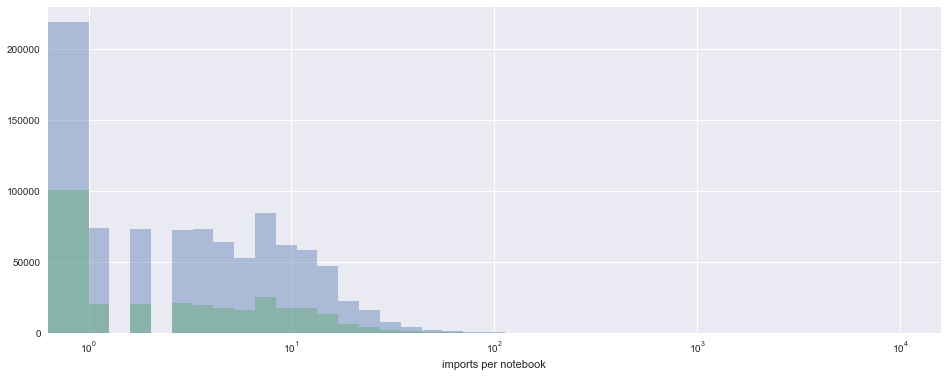

In [349]:
fig, ax = plt.subplots(figsize=(16,6))

sns.distplot(unforked_df_cell_counts.num_imports, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))
sns.distplot(forked_df_cell_counts.num_imports, kde=False, ax=ax, bins = np.append(0, np.logspace(0,4,40)))

ax.set_xscale('log')
ax.set_xlabel('imports per notebook')

print('Median %s imports per unforked notebook' % unforked_df_cell_counts.num_imports.median())
print('Median %s imports per forked notebook' % forked_df_cell_counts.num_imports.median())
print('Median %s imports per notebook forked 10+ times' % forked_df_cell_counts_10.num_imports.median())
print('Median %s imports per notebook forked 100+ times' % forked_df_cell_counts_100.num_imports.median())
print(ttest_ind(unforked_df_cell_counts.lines_of_code, forked_df_cell_counts.num_imports))
print('')
print('Removing Notebooks with no imports at all')
print('Median %s imports per unforked notebook' % unforked_df_cell_counts[unforked_df_cell_counts.num_imports > 0].num_imports.median())
print('Median %s imports per forked notebook' % forked_df_cell_counts.num_imports[forked_df_cell_counts.num_imports > 0].median())
print('Median %s imports per notebook forked 10+ times' % forked_df_cell_counts_10.num_imports[forked_df_cell_counts_10.num_imports > 0].median())
print('Median %s imports per notebook forked 100+ times' % forked_df_cell_counts_100.num_imports[forked_df_cell_counts_100.num_imports > 0].median())
print(ttest_ind(unforked_df_cell_counts[unforked_df_cell_counts.num_imports > 0].num_imports, forked_df_cell_counts[forked_df_cell_counts.num_imports > 0].num_imports))


Picking up again, can we remove the 0s and nan numbers from our word counts and still get the result?


In [275]:
print(str(657420 / 934165)[0:5] + ' of unforked notebooks have markdown')
print(str(233489 / 302429)[0:5] + ' of forked notebooks have markdown')

0.703 of unforked notebooks have markdown
0.772 of forked notebooks have markdown


# 10.0 Readmes

Repos that have been forked more often seem to have longer readme files

## 10.1 Readme size versus forked count

In [131]:
df_repo_complete.columns = ['Unnamed: 0', 'created_at', 'description', 'fork', 'forks_count',
       'has_downloads', 'has_issues', 'has_pages', 'has_wiki', 'html_url',
       'repo_id', 'language', 'name', 'network_count', 'open_issues_count',
       'owner_id', 'owner_login', 'owner_type', 'private', 'pushed_at', 'size',
       'stargazers_count', 'subscribers_count', 'updated_at',
       'watchers_count']
del df_repo_complete['Unnamed: 0']

df_readme = pd.read_csv('../data/csv/repo_readme.csv')
del df_readme['Unnamed: 0']
df_readme.columns = ['readme_content', 'readme_html_url', 'readme_name', 'readme_path', 'repo_id', 'readme_size', 'readme_type']

df_repo_readme = df_repo_complete.merge(df_readme, how = 'left', on='repo_id')

df_repo_readme.head()

df_repo_readme_dropped = df_repo_readme[df_repo_readme.readme_size.notnull()]
df_repo_readme_filled = df_repo_readme.readme_size.fillna(0)

Median of 161.0 byte readme for unforked repos
Median of 764.0 byte readme for forked repos
Median of 2052.0 byte readme for repos forked 10+ times
Median of 3511.0 byte readme for repos forked 100+ times


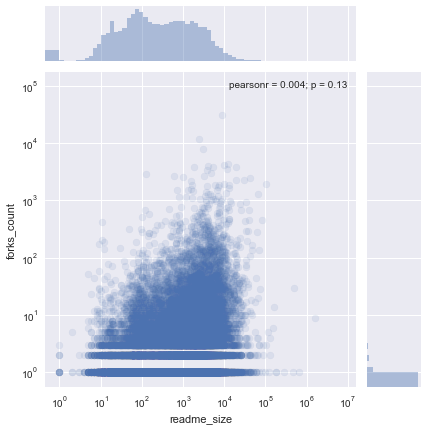

In [351]:
mybins = np.append(0, np.logspace(0,5,50))
g = sns.jointplot("readme_size", "forks_count", data=df_repo_readme_dropped, marginal_kws=dict(bins=mybins), joint_kws={'alpha':0.1})
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

print('Median of %s byte readme for unforked repos' % df_repo_readme_dropped[df_repo_readme_dropped.forks_count == 0].readme_size.median())
print('Median of %s byte readme for forked repos' % df_repo_readme_dropped[df_repo_readme_dropped.forks_count > 0].readme_size.median())
print('Median of %s byte readme for repos forked 10+ times' % df_repo_readme_dropped[df_repo_readme_dropped.forks_count > 9].readme_size.median())
print('Median of %s byte readme for repos forked 100+ times' % df_repo_readme_dropped[df_repo_readme_dropped.forks_count > 99].readme_size.median())


# End

And that's the end of the exploration. It is a little messy and incomplete. We ended up doing several other follow-up analyses but this is the core of it.